# Credit Card Scoring Model
- Authors: Gian Luky Saputra & Daud Muhamad A
- Date: January 2024

This notebook develop a credit scoring model that aids in supporting the company's crucial lending decisions. Evaluate loan applicant's ability to make repayment to enable a well-informed lending decisions. There are 3 models which will assist in determining which applicants are eligible for loans, the suitable interest rates for each applicant, and their credit limits based on their repayment capacity and risks.

## LIBRARY

In [2]:
import random as rd
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, RepeatedStratifiedKFold, RepeatedKFold
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, OrdinalEncoder, RobustScaler, OneHotEncoder

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, recall_score, auc, roc_auc_score
from sklearn.metrics import f1_score, balanced_accuracy_score, fbeta_score, precision_recall_curve, roc_curve

import sklearn
sklearn.metrics.get_scorer_names()

# from scipy.stats import pearsonr

# # Linear and Trees
# # for baseline only, wont do any optimization.
from sklearn.linear_model import LogisticRegression, RidgeClassifier, ElasticNet

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

# # NN (later on, not yet searching)
# from tensorflow import keras
# from tensorflow.keras import layers

## Variable Description

In [3]:
df_var = pd.read_csv('/kaggle/input/stc2024/variable_description.csv')
pd.set_option('display.max_colwidth', None)
display(df_var.iloc[:,1:])

,Columns,Description
0,U_ID,Loan ID
1,FLAG,"Target variable (1 - client with late payment more than X days, 0 - all other cases)"
2,CONTRACT_TYPE,Identification if loan is cash or revolving
3,GENDER,Gender of the client
4,NUM_OF_CHILDREN,Number of children the client has
5,INCOME,Monthly income of the client
6,APPROVED_CREDIT,Approved credit amount of the loan
7,LOAN_ANNUITY,Loan annuity (amount that must be paid monthly)
8,PRODUCT_PRICE,For consumer loans it is the price of the goods for which the loan is given
9,INCOME_CATEGORY,"Clients income type (businessman, working, maternity leave,…)"


## Loading Data

In [4]:
df_his = pd.read_csv('/kaggle/input/stc2024/payment_history.csv')
df_pre = pd.read_csv('/kaggle/input/stc2024/previous_applications.csv')
df_tr = pd.read_csv('/kaggle/input/stc2024/train.csv')
df_te = pd.read_csv('/kaggle/input/stc2024/test.csv')

In [5]:
pd.set_option('display.max_columns', None)

display(df_tr.head())
display(df_te.head())
df_tr.info()
df_te.info()

display(df_his.head())
display(df_pre.head(10))
df_his.info()
df_pre.info()

,U_ID,FLAG,CONTRACT_TYPE,GENDER,NUM_OF_CHILDREN,INCOME,APPROVED_CREDIT,LOAN_ANNUITY,PRODUCT_PRICE,INCOME_CATEGORY,EDUCATION,FAMILY_STATUS,HOUSING_CATEGORY,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_SINCE_ID_CHANGE,APPLY_DAYS,APPLY_HOUR,ORGANIZATION_CATEGORY,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3
0,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,Secondary / secondary special,Married,With parents,-11539,-921,-119.0,-2757,TUESDAY,18,Business Entity Type 3,0.572805,0.608276,NaN
1,406644,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15743,-4482,-1797.0,-2455,TUESDAY,14,Other,0.655600,0.684298,NaN
2,259130,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-20775,365243,-8737.0,-4312,THURSDAY,14,NA1,NaN,0.580687,0.749022
3,411997,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,State servant,Higher education,Married,House / apartment,-20659,-10455,-4998.0,-4010,WEDNESDAY,10,Culture,NaN,0.623740,0.710674
4,241559,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-9013,-1190,-3524.0,-1644,SUNDAY,11,Construction,0.175511,0.492994,0.085595


,U_ID,FLAG,CONTRACT_TYPE,GENDER,NUM_OF_CHILDREN,INCOME,APPROVED_CREDIT,LOAN_ANNUITY,PRODUCT_PRICE,INCOME_CATEGORY,EDUCATION,FAMILY_STATUS,HOUSING_CATEGORY,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_SINCE_ID_CHANGE,APPLY_DAYS,APPLY_HOUR,ORGANIZATION_CATEGORY,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3
0,219092,0,Cash loans,M,3,135000.0,871029.0,44604.0,765000.0,Working,Secondary / secondary special,Married,House / apartment,-17598,-2650,-1411.0,-1131,SATURDAY,7,Business Entity Type 3,NaN,0.145475,0.651260
1,141577,0,Cash loans,F,0,144000.0,485640.0,34537.5,450000.0,Working,Higher education,Married,Office apartment,-14097,-7408,-7908.0,-4872,MONDAY,14,Kindergarten,NaN,0.682675,NaN
2,180205,0,Cash loans,F,1,90000.0,247500.0,8887.5,247500.0,Working,Secondary / secondary special,Married,House / apartment,-18384,-2826,-8226.0,-1930,SATURDAY,12,Self-employed,0.814700,0.686312,0.758393
3,357381,0,Cash loans,M,2,112500.0,506889.0,24781.5,418500.0,Working,Secondary / secondary special,Married,House / apartment,-12170,-926,-916.0,-4048,THURSDAY,13,Other,0.399219,0.266520,0.058826
4,271229,0,Cash loans,M,0,216000.0,450000.0,21888.0,450000.0,Working,Incomplete higher,Married,House / apartment,-10790,-577,-4640.0,-2035,MONDAY,14,Business Entity Type 3,0.368452,0.610483,0.392774


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   U_ID                   61503 non-null  int64  
 1   FLAG                   61503 non-null  int64  
 2   CONTRACT_TYPE          61503 non-null  object 
 3   GENDER                 61503 non-null  object 
 4   NUM_OF_CHILDREN        61503 non-null  int64  
 5   INCOME                 61503 non-null  float64
 6   APPROVED_CREDIT        61503 non-null  float64
 7   LOAN_ANNUITY           61502 non-null  float64
 8   PRODUCT_PRICE          61441 non-null  float64
 9   INCOME_CATEGORY        61503 non-null  object 
 10  EDUCATION              61503 non-null  object 
 11  FAMILY_STATUS          61503 non-null  object 
 12  HOUSING_CATEGORY       61503 non-null  object 
 13  DAYS_AGE               61503 non-null  int64  
 14  DAYS_WORK              61503 non-null  int64  
 15  DA

,SK_ID_PREV,U_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
0,1137312,164489,12,-1384.0,-1417.0,5970.375,5970.375
1,2723183,112102,14,-197.0,-197.0,70.740,70.740
2,2558880,154793,8,-1262.0,-1269.0,15031.080,15031.080
3,1410565,197687,1,-1037.0,-1048.0,12514.050,12510.450
4,2391610,183431,20,-1680.0,-1693.0,7875.000,7875.000


,SK_ID_PREV,U_ID,CONTRACT_TYPE,LOAN_ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRODUCT_PRICE,APPLY_DAYS,APPLY_HOUR,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Approved,-73,12.0,middle,365243.0,-42.0,-37.0,0.0
1,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Approved,-512,12.0,middle,365243.0,-482.0,-177.0,1.0
2,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,Approved,-684,18.0,low_normal,365243.0,-654.0,-137.0,1.0
3,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,Canceled,-14,NaN,NA1,NaN,NaN,NaN,NaN
4,1715995,447712,Cash loans,11368.620,270000.0,335754.0,NaN,270000.0,FRIDAY,7,Approved,-735,54.0,low_normal,365243.0,-705.0,-334.0,1.0
5,1151694,161591,Consumer loans,39111.075,214380.0,209497.5,13500.0,214380.0,FRIDAY,12,Approved,-989,6.0,middle,365243.0,-958.0,-804.0,0.0
6,2057616,304455,Consumer loans,15542.730,129505.5,131112.0,9000.0,129505.5,WEDNESDAY,12,Approved,-406,10.0,middle,365243.0,-374.0,-101.0,0.0
7,2586290,447421,Consumer loans,10274.040,126544.5,101232.0,25312.5,126544.5,SATURDAY,15,Approved,-243,12.0,middle,365243.0,-212.0,-116.0,0.0
8,2203764,205177,Cash loans,34423.110,450000.0,491580.0,NaN,450000.0,WEDNESDAY,17,Approved,-880,24.0,high,365243.0,-850.0,-720.0,1.0
9,1946657,427532,Consumer loans,7795.125,147195.0,172840.5,0.0,147195.0,SUNDAY,11,Approved,-1327,24.0,low_action,365243.0,-1296.0,-990.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872306 entries, 0 to 2872305
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   SK_ID_PREV   int64  
 1   U_ID         int64  
 2   INST_NUMBER  int64  
 3   INST_DAYS    float64
 4   PAY_DAYS     float64
 5   AMT_INST     float64
 6   AMT_PAY      float64
dtypes: float64(4), int64(3)
memory usage: 153.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350712 entries, 0 to 350711
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SK_ID_PREV                 350712 non-null  int64  
 1   U_ID                       350712 non-null  int64  
 2   CONTRACT_TYPE              350712 non-null  object 
 3   LOAN_ANNUITY               274103 non-null  float64
 4   APPLICATION                350712 non-null  float64
 5   APPROVED_CREDIT            350712 non-null  float64
 6   AMT_DOWN_PAYMENT           164

In [6]:
# df_his.describe()
display(df_tr.shape, df_te.shape, df_his.shape, df_pre.shape)

(61503, 23)

(14761, 23)

(2872306, 7)

(350712, 18)

# 1. Business Understanding
### a. Ringkasan Narasi :
    STC Paylater, sebagai perusahaan fiktif penyedia layanan Buy Now Pay Later (BNPL), mengandalkan pemberian pinjaman sebagai sumber pendapatan utamanya. Namun, risiko utama yang dihadapi adalah potensi peminjam tidak memenuhi kewajiban pembayaran pinjaman, yang dapat menyebabkan kerugian keuangan bagi perusahaan.
    
    Untuk mengurangi risiko ini, sangat penting bagi STC Paylater untuk membuat keputusan yang terinformasi (berbasis data) tentang siapa yang layak menerima pinjaman, tingkat bunga yang harus dikenakan, dan jumlah pinjaman yang dapat disetujui. Dalam konteks ini, perusahaan memerlukan model penilaian kredit yang dapat membantu dalam membuat keputusan pemberian pinjaman yang cerdas. Tujuan utama adalah mengevaluasi kemampuan setiap peminjam untuk melakukan pembayaran yang dapat mendukung keputusan pemberian pinjaman yang terinformasi.

# 2. Data Understanding
## Preprocessing 1
For app_train and app_test 
1. Tidak terdapat duplikat pada dataset.
2. Mengubah nilai ‘Unemployed’, ‘Student’, dan ‘Businessman’ pada fitur Income Category menjadi ‘Other’. Karena proporsinya yang sangat kecil (0.0146%).
3. Mengubah nilai ‘NA1’ pada fitur Organization Category menjadi ‘Other’.
4. Membuang unsur type pada fitur Organization Category.<br>
    **Contoh**: ‘Industry: type 11’ diubah menjadi ‘Industry’
5. Mengubah nilai 365243 pada fitur Days Work menjadi 0, karena satu-satunya nilai unik yang positif dan terdapat pada 11.253 observasi (baris).
6. Membentuk fitur Years Age, Years Work, Years Registration, dan Years Since Id Change. Diperoleh dengan mengekstrak nilai pada fitur Days Age, Days Work, Days Registration, dan Days Since Id Change menjadi tahun dalam format integer. <br>
    **Contoh**: Years Age = Days Age/-365 <br>
    kemudian nilai ini dibulatkan sehingga menjadi bilangan bulat (integer. <br>
7. Mengubah nilai negatif pada fitur Years Age menjadi 0, artinya calon peminjam sedang tidak bekerja saat ini.

In [7]:
# for k in df_tr.columns[df_tr.nunique()<60].drop("FLAG"):
#     print(df_tr[k].value_counts())
#     print("\n")
# df_pre.TERMINATION.value_counts()

# ## Identifikasi nilai unik setiap fitur
# for k in df_tr.columns.drop("U_ID"):
#     print(df_tr[k].value_counts())
#     print("\n")

In [8]:
## Train
df_tr0 = df_tr.copy()

# categorical column
df_tr0["INCOME_CATEGORY"].replace("Unemployed, Student, Businessman".split(", "), "Other", inplace=True)
df_tr0["ORGANIZATION_CATEGORY"].replace("NA1", 'Other', inplace=True)
df_tr0['ORGANIZATION_CATEGORY'] = (df_tr0.ORGANIZATION_CATEGORY.str.split(":", expand=True)[0]).str.split("Ty", expand=True)[0]

# numerical column
# kol_money = "income approved_credit loan_annuity product_price".upper().split(" ")
# df_tr0[kol_money] = df_tr0[kol_money].apply(lambda x: x/1000)

df_tr0['DAYS_WORK'].replace(365243, 0, inplace= True)

df_tr0.columns = df_tr0.columns.str.replace("DAYS_", "YEARS_")
kol_years = df_tr0.columns[df_tr0.columns.str.startswith("YEARS")]
df_tr0[kol_years] = df_tr0[kol_years].apply(lambda x: x/-365)
df_tr0["YEARS_WORK"] = [max(j, 0) for j in df_tr0.YEARS_WORK]
df_tr0[kol_years] = df_tr0[kol_years].astype(int)

display(df_tr0.head())

,U_ID,FLAG,CONTRACT_TYPE,GENDER,NUM_OF_CHILDREN,INCOME,APPROVED_CREDIT,LOAN_ANNUITY,PRODUCT_PRICE,INCOME_CATEGORY,EDUCATION,FAMILY_STATUS,HOUSING_CATEGORY,YEARS_AGE,YEARS_WORK,YEARS_REGISTRATION,YEARS_SINCE_ID_CHANGE,APPLY_DAYS,APPLY_HOUR,ORGANIZATION_CATEGORY,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3
0,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,Secondary / secondary special,Married,With parents,31,2,0,7,TUESDAY,18,Business Entity,0.572805,0.608276,NaN
1,406644,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,43,12,4,6,TUESDAY,14,Other,0.655600,0.684298,NaN
2,259130,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,Pensioner,Secondary / secondary special,Married,House / apartment,56,0,23,11,THURSDAY,14,Other,NaN,0.580687,0.749022
3,411997,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,State servant,Higher education,Married,House / apartment,56,28,13,10,WEDNESDAY,10,Culture,NaN,0.623740,0.710674
4,241559,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,24,3,9,4,SUNDAY,11,Construction,0.175511,0.492994,0.085595


In [9]:
## Test
df_te0 = df_te.copy()

# categorical column
df_te0["INCOME_CATEGORY"].replace("Unemployed, Student, Businessman".split(", "), "Other", inplace=True)
df_te0["ORGANIZATION_CATEGORY"].replace("NA1", 'Other', inplace=True)
df_te0['ORGANIZATION_CATEGORY'] = (df_te0.ORGANIZATION_CATEGORY.str.split(":", expand=True)[0]).str.split("Ty", expand=True)[0]

# numerical column
# df_te0[kol_money] = df_te0[kol_money].apply(lambda x: x/1000)

df_te0['DAYS_WORK'].replace(365243, 0, inplace= True)

df_te0.columns = df_te0.columns.str.replace("DAYS_", "YEARS_")
df_te0[kol_years] = df_te0[kol_years].apply(lambda x: x/-365)
df_te0["YEARS_WORK"] = [max(j, 0) for j in df_te0.YEARS_WORK]
df_te0[kol_years] = df_te0[kol_years].astype(int)

display(df_te0.head())

,U_ID,FLAG,CONTRACT_TYPE,GENDER,NUM_OF_CHILDREN,INCOME,APPROVED_CREDIT,LOAN_ANNUITY,PRODUCT_PRICE,INCOME_CATEGORY,EDUCATION,FAMILY_STATUS,HOUSING_CATEGORY,YEARS_AGE,YEARS_WORK,YEARS_REGISTRATION,YEARS_SINCE_ID_CHANGE,APPLY_DAYS,APPLY_HOUR,ORGANIZATION_CATEGORY,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3
0,219092,0,Cash loans,M,3,135000.0,871029.0,44604.0,765000.0,Working,Secondary / secondary special,Married,House / apartment,48,7,3,3,SATURDAY,7,Business Entity,NaN,0.145475,0.651260
1,141577,0,Cash loans,F,0,144000.0,485640.0,34537.5,450000.0,Working,Higher education,Married,Office apartment,38,20,21,13,MONDAY,14,Kindergarten,NaN,0.682675,NaN
2,180205,0,Cash loans,F,1,90000.0,247500.0,8887.5,247500.0,Working,Secondary / secondary special,Married,House / apartment,50,7,22,5,SATURDAY,12,Self-employed,0.814700,0.686312,0.758393
3,357381,0,Cash loans,M,2,112500.0,506889.0,24781.5,418500.0,Working,Secondary / secondary special,Married,House / apartment,33,2,2,11,THURSDAY,13,Other,0.399219,0.266520,0.058826
4,271229,0,Cash loans,M,0,216000.0,450000.0,21888.0,450000.0,Working,Incomplete higher,Married,House / apartment,29,1,12,5,MONDAY,14,Business Entity,0.368452,0.610483,0.392774


## EDA

#### FLAG Distribution

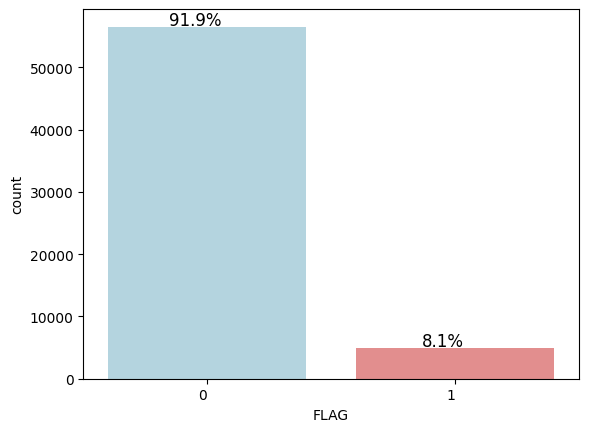

In [10]:
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height() + 300
        ax.annotate(percentage, (x, y), size=12, ha='center')  
    ax.set_ylim(0, max(ax.patches[-1].get_height() + 1000, ax.get_ylim()[1]))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  
    ax.tick_params(axis='x', labelsize=10, rotation=0)
    plt.show()

color_palette = ["lightblue", "lightcoral"]
ax = sns.countplot(x="FLAG", data=df_tr0, palette=color_palette)
without_hue(ax, df_tr0.FLAG)

In [11]:
kol_kat = df_tr0.select_dtypes("object").columns
kol_num = df_tr0.columns[df_tr0.dtypes !=  "object"].drop(["FLAG", "U_ID"])
len(kol_kat), len(kol_num), df_tr0.shape

(8, 13, (61503, 23))

#### Numeric Feature

In [12]:
fig, axes = plt.subplots(3, 5, figsize=(15, 15), sharey=False)
axes = axes.ravel()

for i, var in enumerate(kol_num):
    sns.boxenplot(data=df_tr0, y=var, x="FLAG", ax=axes[i], palette="viridis")
    
    axes[i].set_title(f'{var}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# 10% sampel as its
rd.seed(123)
rdsam = rd.sample(sorted(df_tr0.index), 6000)
samp = df_tr0.drop('U_ID', axis = 1).loc[rdsam,:]

plt.figure(figsize = (20, 10))
sns.heatmap(vmin=-1, vmax=1, data = samp.select_dtypes(exclude = "object").corr(), annot = True, cmap="RdBu")
plt.show()

plt.figure(figsize = (6, 4))
sns.pairplot(samp.select_dtypes("float"))

#### Categoric Features

In [14]:
# #  Bar Plot
# fig, axes = plt.subplots(2, 4, figsize=(20, 16), sharey=False)
# axes = axes.ravel()

# for i, var in enumerate(kol_kat):

#     tbl = pd.crosstab(df_tr0[var], df_tr0["FLAG"])
#     tbl.plot(kind="bar", stacked=True, color=["lightblue", "lightcoral"], ax=axes[i])

#     axes[i].set_title(f'FLAG by {var}', fontsize=12, fontweight='bold')
    
#     axes[i].set_ylabel('FLAG')
#     if i == len(kol_kat) - 1:
#         axes[i].tick_params(axis='x', rotation=90)
#     else:
#         axes[i].tick_params(axis='x', rotation=45)
#     pass

# plt.tight_layout()


# #  Bar Plot
fig, axes = plt.subplots(2, 4, figsize=(20, 16), sharey=False)
axes = axes.ravel()

for i, var in enumerate(kol_kat):
    tbl = pd.crosstab(df_tr0[var], df_tr0["FLAG"], normalize="index")
    tbl.plot(kind="bar", stacked=True, color=["lightblue", "lightcoral"], ax=axes[i])
    axes[i].set_title(f'FLAG by {var}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('FLAG')
    
    if i == len(kol_kat) - 1:
        axes[i].tick_params(axis='x', rotation=90)
    else:
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()

# Barplot
fig, axes = plt.subplots(2, 4, figsize=(20, 16), sharey=False)
axes = axes.ravel()
for i, var in enumerate(kol_kat):
    tbl = pd.crosstab(df_tr0['FLAG'], df_tr0[var], normalize="index")
    tbl.plot(kind="bar", stacked=True, ax=axes[i], color=sns.color_palette("Set1"))
    axes[i].set_title(f'FLAG by {var}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('FLAG')
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()

# 3. Data Preparation

#### Identifikasi Missing Values

,0,1
U_ID,61503,0.000000
FLAG,2,0.000000
CONTRACT_TYPE,2,0.000000
GENDER,2,0.000000
NUM_OF_CHILDREN,10,0.000000
INCOME,861,0.000000
APPROVED_CREDIT,3562,0.000000
LOAN_ANNUITY,9374,0.001626
PRODUCT_PRICE,541,0.100808
INCOME_CATEGORY,5,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   U_ID                   61503 non-null  int64  
 1   FLAG                   61503 non-null  int64  
 2   CONTRACT_TYPE          61503 non-null  object 
 3   GENDER                 61503 non-null  object 
 4   NUM_OF_CHILDREN        61503 non-null  int64  
 5   INCOME                 61503 non-null  float64
 6   APPROVED_CREDIT        61503 non-null  float64
 7   LOAN_ANNUITY           61502 non-null  float64
 8   PRODUCT_PRICE          61441 non-null  float64
 9   INCOME_CATEGORY        61503 non-null  object 
 10  EDUCATION              61503 non-null  object 
 11  FAMILY_STATUS          61503 non-null  object 
 12  HOUSING_CATEGORY       61503 non-null  object 
 13  YEARS_AGE              61503 non-null  int64  
 14  YEARS_WORK             61503 non-null  int64  
 15  YE

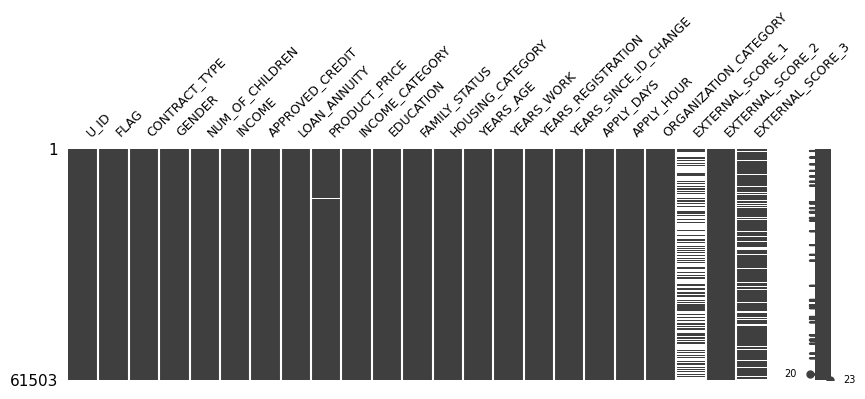

In [15]:
msno.matrix(df_tr0, figsize=(10,3), fontsize=9)
display(pd.concat([df_tr0.nunique(), df_tr0.isna().sum()/df_tr0.shape[0]*100], axis=1))
df_tr0.info()

In [16]:
## TRAIN
df_tr1 = df_tr0.copy()
df_pre1 = df_pre.copy()

# Ordinal/Label Encoding
df_tr1["EDUCATION"].replace("Secondary / secondary special, Higher education, Incomplete higher, Lower secondary, Academic degree".split(", "),
                            [1,3,2,0,4],inplace=True)

# Feature Engineering
df_tr1['EXT_NA'] = df_tr1.loc[:, df_tr1.columns.str.startswith('EXT')].isna().sum(1)

n_LN = df_pre1[df_pre1.CONTRACT_STATUS == "Approved"].U_ID.value_counts()
df_tr1['PRE_LN'] = df_tr1['U_ID'].map(n_LN)
df_tr1['PRE_LN'] = df_tr1['PRE_LN'].fillna(0)

n_LNR = df_pre1[df_pre1.CONTRACT_STATUS == "Refused"].U_ID.value_counts()
df_tr1['PRE_LN_R'] = df_tr1['U_ID'].map(n_LNR)
df_tr1['PRE_LN_R'] = df_tr1['PRE_LN_R'].fillna(0)

df_temp = df_his.copy()
df_temp['LATE'] = (df_temp['INST_DAYS'] < df_temp['PAY_DAYS']).astype(int)
n_LT = df_temp.groupby('U_ID')['LATE'].sum()
df_tr1['PRE_LATE'] = df_tr1['U_ID'].map(n_LT)
df_tr1['PRE_LATE'] = df_tr1['PRE_LATE'].apply(lambda x: 1 if x > 0 else 0)
df_tr1[['PRE_LATE']] = df_tr1[['PRE_LATE']].fillna(0)

df_pre1["TERMINATION"].replace(365243.0, np.nan, inplace = True)
n_TM90 = df_pre1[df_pre1.TERMINATION >= -90].U_ID.value_counts()
df_tr1['PRE_TM90'] = df_tr1['U_ID'].map(n_TM90)
df_tr1['PRE_TM90'] = df_tr1['PRE_TM90'].fillna(0)

display(df_tr1.head(10), df_tr1.shape)

,U_ID,FLAG,CONTRACT_TYPE,GENDER,NUM_OF_CHILDREN,INCOME,APPROVED_CREDIT,LOAN_ANNUITY,PRODUCT_PRICE,INCOME_CATEGORY,EDUCATION,FAMILY_STATUS,HOUSING_CATEGORY,YEARS_AGE,YEARS_WORK,YEARS_REGISTRATION,YEARS_SINCE_ID_CHANGE,APPLY_DAYS,APPLY_HOUR,ORGANIZATION_CATEGORY,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3,EXT_NA,PRE_LN,PRE_LN_R,PRE_LATE,PRE_TM90
0,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,1,Married,With parents,31,2,0,7,TUESDAY,18,Business Entity,0.572805,0.608276,NaN,1,1.0,0.0,0,0.0
1,406644,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,Commercial associate,1,Married,House / apartment,43,12,4,6,TUESDAY,14,Other,0.655600,0.684298,NaN,1,8.0,0.0,1,0.0
2,259130,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,Pensioner,1,Married,House / apartment,56,0,23,11,THURSDAY,14,Other,NaN,0.580687,0.749022,1,4.0,1.0,0,1.0
3,411997,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,State servant,3,Married,House / apartment,56,28,13,10,WEDNESDAY,10,Culture,NaN,0.623740,0.710674,1,4.0,0.0,1,0.0
4,241559,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,Commercial associate,1,Single / not married,House / apartment,24,3,9,4,SUNDAY,11,Construction,0.175511,0.492994,0.085595,0,5.0,1.0,1,0.0
5,296530,0,Cash loans,F,2,135000.0,592560.0,32274.0,450000.0,Working,3,Married,House / apartment,28,2,0,0,WEDNESDAY,9,Business Entity,0.117463,0.621860,0.579727,0,1.0,0.0,0,0.0
6,266655,0,Cash loans,F,0,90000.0,71109.0,5746.5,54000.0,Working,1,Married,Municipal apartment,53,4,18,8,TUESDAY,16,Self-employed,NaN,0.022757,0.420611,1,4.0,4.0,1,0.0
7,305500,0,Cash loans,F,0,112500.0,562500.0,16578.0,562500.0,State servant,3,Married,House / apartment,45,3,19,0,TUESDAY,16,University,0.570466,0.416949,0.590233,0,6.0,0.0,1,0.0
8,108004,0,Cash loans,F,1,112500.0,360000.0,17509.5,360000.0,Working,1,Married,House / apartment,26,2,4,2,MONDAY,12,Kindergarten,0.407390,0.452447,0.321735,0,2.0,6.0,0,0.0
9,231371,0,Cash loans,F,1,112500.0,512446.5,34375.5,463500.0,Working,1,Civil marriage,House / apartment,28,1,4,7,TUESDAY,16,Business Entity,0.310480,0.642651,0.466864,0,2.0,0.0,0,0.0


(61503, 28)

In [17]:
## TEST
df_te1 = df_te0.copy()

# Ordinal/Label Encoding
df_te1["EDUCATION"].replace("Secondary / secondary special, Higher education, Incomplete higher, Lower secondary, Academic degree".split(", "),
                            [1,3,2,0,4],inplace=True)

# Feature Engineering
df_te1['EXT_NA'] = df_te1.loc[:, df_te1.columns.str.startswith('EXT')].isna().sum(1)

df_te1['PRE_LN'] = df_te1['U_ID'].map(n_LN)
df_te1['PRE_LN'] = df_te1['PRE_LN'].fillna(0)

df_te1['PRE_LN_R'] = df_te1['U_ID'].map(n_LNR)
df_te1['PRE_LN_R'] = df_te1['PRE_LN_R'].fillna(0)

df_te1['PRE_LATE'] = df_te1['U_ID'].map(n_LT)
df_te1['PRE_LATE'] = df_te1['PRE_LATE'].apply(lambda x: 1 if x > 0 else 0)
df_te1[['PRE_LATE']] = df_te1[['PRE_LATE']].fillna(0)

df_te1['PRE_TM90'] = df_te1['U_ID'].map(n_TM90)
df_te1['PRE_TM90'] = df_te1['PRE_TM90'].fillna(0)

display(df_te1.head(10), df_te1.shape)

,U_ID,FLAG,CONTRACT_TYPE,GENDER,NUM_OF_CHILDREN,INCOME,APPROVED_CREDIT,LOAN_ANNUITY,PRODUCT_PRICE,INCOME_CATEGORY,EDUCATION,FAMILY_STATUS,HOUSING_CATEGORY,YEARS_AGE,YEARS_WORK,YEARS_REGISTRATION,YEARS_SINCE_ID_CHANGE,APPLY_DAYS,APPLY_HOUR,ORGANIZATION_CATEGORY,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3,EXT_NA,PRE_LN,PRE_LN_R,PRE_LATE,PRE_TM90
0,219092,0,Cash loans,M,3,135000.0,871029.0,44604.0,765000.0,Working,1,Married,House / apartment,48,7,3,3,SATURDAY,7,Business Entity,NaN,0.145475,0.651260,1,3.0,0.0,1,0.0
1,141577,0,Cash loans,F,0,144000.0,485640.0,34537.5,450000.0,Working,3,Married,Office apartment,38,20,21,13,MONDAY,14,Kindergarten,NaN,0.682675,NaN,2,1.0,0.0,1,0.0
2,180205,0,Cash loans,F,1,90000.0,247500.0,8887.5,247500.0,Working,1,Married,House / apartment,50,7,22,5,SATURDAY,12,Self-employed,0.814700,0.686312,0.758393,0,3.0,0.0,1,0.0
3,357381,0,Cash loans,M,2,112500.0,506889.0,24781.5,418500.0,Working,1,Married,House / apartment,33,2,2,11,THURSDAY,13,Other,0.399219,0.266520,0.058826,0,2.0,9.0,1,0.0
4,271229,0,Cash loans,M,0,216000.0,450000.0,21888.0,450000.0,Working,2,Married,House / apartment,29,1,12,5,MONDAY,14,Business Entity,0.368452,0.610483,0.392774,0,6.0,0.0,0,0.0
5,374711,0,Cash loans,F,0,58500.0,135000.0,7321.5,135000.0,Working,1,Single / not married,With parents,29,8,8,9,TUESDAY,10,Security,0.501097,0.067371,0.199771,0,3.0,1.0,1,0.0
6,400364,0,Cash loans,F,2,90000.0,260640.0,18666.0,225000.0,Working,3,Married,House / apartment,31,11,5,11,MONDAY,15,Business Entity,0.662708,0.461933,NaN,1,4.0,0.0,1,0.0
7,133189,0,Cash loans,F,2,112500.0,900297.0,32026.5,751500.0,Pensioner,1,Married,House / apartment,42,0,2,12,FRIDAY,11,Other,NaN,0.585264,0.562060,1,1.0,0.0,0,0.0
8,146009,0,Cash loans,F,0,112500.0,665892.0,19210.5,477000.0,Pensioner,1,Married,House / apartment,56,0,2,10,MONDAY,13,Other,0.699160,0.673492,0.510090,0,1.0,0.0,1,0.0
9,327796,0,Cash loans,F,2,90000.0,284400.0,13833.0,225000.0,Working,1,Married,House / apartment,28,4,7,8,MONDAY,10,Business Entity,0.619382,0.567921,0.547810,0,1.0,0.0,0,0.0


(14761, 28)

# 4. Modeling 1 : Flag Classification

### Splitting Data

In [18]:
# define train and test
Xtr1 = df_tr1.drop("u_id approved_credit loan_annuity".upper().split(" "), axis=1)
Xte1 = df_te1.drop("u_id approved_credit loan_annuity".upper().split(" "), axis=1)

ytr1 = Xtr1.pop("FLAG")
yte1 = Xte1.pop("FLAG")

# splitting data train into valid and train (valid for yeah?)
Xtr1, Xva1, ytr1, yva1 = train_test_split(Xtr1, ytr1, test_size = 0.1, random_state=0, stratify=ytr1)
display(Xtr1.head(), Xva1.tail())

,CONTRACT_TYPE,GENDER,NUM_OF_CHILDREN,INCOME,PRODUCT_PRICE,INCOME_CATEGORY,EDUCATION,FAMILY_STATUS,HOUSING_CATEGORY,YEARS_AGE,YEARS_WORK,YEARS_REGISTRATION,YEARS_SINCE_ID_CHANGE,APPLY_DAYS,APPLY_HOUR,ORGANIZATION_CATEGORY,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3,EXT_NA,PRE_LN,PRE_LN_R,PRE_LATE,PRE_TM90
50421,Cash loans,F,2,180000.0,855000.0,Commercial associate,3,Married,House / apartment,40,8,13,14,TUESDAY,17,Trade,0.607205,0.597986,0.450747,0,4.0,2.0,1,0.0
30672,Cash loans,F,0,112500.0,450000.0,Commercial associate,1,Married,House / apartment,55,0,0,10,SATURDAY,9,Medicine,0.563241,0.670388,0.520898,0,6.0,1.0,1,0.0
12891,Cash loans,F,2,90000.0,121500.0,Working,1,Married,House / apartment,32,3,15,10,FRIDAY,13,Industry,NaN,0.354225,0.726711,1,1.0,0.0,0,0.0
47880,Cash loans,M,0,33750.0,90000.0,Pensioner,1,Married,House / apartment,61,0,29,11,THURSDAY,7,Other,NaN,0.524490,NaN,2,1.0,0.0,1,0.0
40664,Cash loans,F,0,180000.0,1102500.0,Pensioner,1,Married,Municipal apartment,60,0,0,12,THURSDAY,10,Other,NaN,0.311483,0.465069,1,2.0,0.0,0,0.0


,CONTRACT_TYPE,GENDER,NUM_OF_CHILDREN,INCOME,PRODUCT_PRICE,INCOME_CATEGORY,EDUCATION,FAMILY_STATUS,HOUSING_CATEGORY,YEARS_AGE,YEARS_WORK,YEARS_REGISTRATION,YEARS_SINCE_ID_CHANGE,APPLY_DAYS,APPLY_HOUR,ORGANIZATION_CATEGORY,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3,EXT_NA,PRE_LN,PRE_LN_R,PRE_LATE,PRE_TM90
44929,Cash loans,M,0,135000.0,148500.0,Working,3,Married,House / apartment,41,7,0,0,TUESDAY,9,Construction,NaN,0.563526,NaN,2,1.0,4.0,1,0.0
55134,Cash loans,F,2,135000.0,450000.0,Working,1,Married,House / apartment,33,1,2,12,MONDAY,11,Trade,0.409154,0.032586,NaN,1,1.0,0.0,1,0.0
20064,Cash loans,F,2,135000.0,688500.0,Working,1,Married,House / apartment,29,9,13,6,SUNDAY,8,Self-employed,0.415968,0.375478,0.662638,0,6.0,0.0,0,0.0
27905,Revolving loans,F,1,157500.0,157500.0,Working,1,Single / not married,House / apartment,37,1,19,14,SUNDAY,12,Business Entity,0.481018,0.445128,0.188490,0,2.0,0.0,0,0.0
50342,Cash loans,F,1,90000.0,225000.0,Commercial associate,3,Separated,With parents,30,0,8,4,WEDNESDAY,14,Business Entity,NaN,0.501975,0.295583,1,1.0,1.0,1,0.0


### Pipeline

In [19]:
kat_kol = Xtr1.select_dtypes("object").columns
num_kol = Xtr1.select_dtypes(exclude="object").columns

# ordinal encoder
kat_trf1 = Pipeline(steps=[
    ("kat_im1", SimpleImputer(strategy="most_frequent")),
    ("kat_en", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ("kat_im2", SimpleImputer(strategy="most_frequent")),
])

kat_trf2 = Pipeline(steps=[
    ("kat_im1", SimpleImputer(strategy="most_frequent")),
    ("kat_en", OneHotEncoder(handle_unknown='ignore')),
    ("kat_im2", SimpleImputer(strategy="most_frequent")),
])

num_trf1 = Pipeline(steps=[("num_im", SimpleImputer(strategy="median")),
                          ('num_sc', RobustScaler())
                         ])

# merge preprocessing
pre1 = ColumnTransformer(transformers=[
    ('kat', kat_trf1, kat_kol),
    ('num', num_trf1, num_kol)
])

# merge preprocessing
pre2 = ColumnTransformer(transformers=[
    ('kat', kat_trf2, kat_kol),
    ('num', num_trf1, num_kol)
])

# FOLD
rkf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=0)

#### Customize Metrics Score

In [20]:
# (tn, fp, fn, tp) --> tg, fb, fg, tb
def statusScorer(y_actual, y_pred):
    cm = confusion_matrix(y_actual, y_pred).ravel().tolist()
    profit = 5*cm[0] + -0*cm[1] + -100*cm[2] + 0*cm[3]
    return profit/sum(cm) 

#sklearn make_scorer for the churnScorer
status_score = make_scorer(statusScorer, greater_is_better = True)

def re0_scorer(y_true, y_pred):    
    return sklearn.metrics.recall_score(y_true, y_pred, pos_label=0)
re0 = make_scorer(re0_scorer)

def pr0_scorer(y_true, y_pred):    
    return sklearn.metrics.precision_score(y_true, y_pred, pos_label=0)
pr0 = make_scorer(pr0_scorer)

## Baseline Model

In [21]:
# Classif Model 1
mods_1 = [
    LogisticRegression(random_state=0, max_iter=500),
    RidgeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    XGBClassifier(random_state=0),
    HistGradientBoostingClassifier(random_state=0),
    LGBMClassifier(random_state=0),
    AdaBoostClassifier(random_state=0),
    CatBoostClassifier(random_state=0, verbose=0),
]

def baseliner_1(models=mods_1, pre=pre1, ver=0):
    res0 = []

    for model in models:
        pipa = imbpipeline(steps=[
            ("preprocess", pre),
            ("clf", model)
        ])

        # weit, how to do? try append for dataframe
        grid_search = GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, 
                                   scoring={"acc": "accuracy", "roc": "roc_auc", "bal":"balanced_accuracy",
                                            "f1m": 'f1_macro', "pre": 'precision', 'rec':'recall', "pr0":pr0, 're0':re0
                                           }, 
                                   refit="roc", verbose=ver)

        grid_search.fit(Xtr1, ytr1)
        hmm = pd.DataFrame(grid_search.cv_results_).iloc[0].to_dict()
        hmm['model'] = type(model).__name__
        # Append the dictionary to the results list
        res0.append(hmm)
        
    res0 = pd.DataFrame(res0)
    
    return res0, grid_search

In [22]:
res_base_1, grid_1 = baseliner_1()
print(res_base_1.filter(regex='^m', axis=1).sort_values(['mean_test_roc'], ascending = False).to_markdown())

**Result**

|    |   mean_fit_time |   mean_score_time |   mean_test_acc |   mean_test_roc |   mean_test_bal |   mean_test_f1m |   mean_test_pre |   mean_test_rec |   mean_test_pr0 |   mean_test_re0 | model                          |
|---:|----------------:|------------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|:-------------------------------|
|  0 |        0.937133 |          0.269094 |        0.919271 |        0.750345 |        0.506765 |        0.493287 |        0.51528  |     0.0147587   |        0.920215 |        0.998772 | LogisticRegression             |
|  1 |        0.309507 |          0.263804 |        0.919226 |        0.749496 |        0.500112 |        0.47918  |        0.333333 |     0.000223564 |        0.919225 |        1        | RidgeClassifier                |
|  4 |        1.11274  |          0.353439 |        0.918738 |        0.74472  |        0.506832 |        0.493761 |        0.423454 |     0.0155412   |        0.920226 |        0.998123 | HistGradientBoostingClassifier |
|  7 |       10.1329   |          0.519083 |        0.918332 |        0.744376 |        0.512067 |        0.504462 |        0.418111 |     0.0275049   |        0.92101  |        0.996629 | CatBoostClassifier             |
|  5 |        1.01497  |          0.282741 |        0.918531 |        0.743819 |        0.509524 |        0.499342 |        0.417112 |     0.0216914   |        0.920629 |        0.997357 | LGBMClassifier                 |
|  6 |        2.92477  |          0.403575 |        0.918928 |        0.742669 |        0.512085 |        0.5042   |        0.471427 |     0.0268337   |        0.921011 |        0.997337 | AdaBoostClassifier             |
|  2 |        7.9639   |          0.901625 |        0.919163 |        0.721343 |        0.502372 |        0.484124 |        0.460648 |     0.00525487  |        0.919561 |        0.999489 | RandomForestClassifier         |
|  3 |        1.29752  |          0.244046 |        0.916507 |        0.719751 |        0.519743 |        0.519397 |        0.366625 |     0.0465124   |        0.922171 |        0.992974 | XGBClassifier                  |


### Hyperparameter Tuning

#### 1. LGBM

In [23]:
lg = imbpipeline(steps=[
    ("preprocess", pre1),
    ("clf", LGBMClassifier(random_state=0))
])

param_grid = {
    'clf__learning_rate': [0.01],
    'clf__n_estimators': [500],
    'clf__max_depth': [8],
    'clf__subsample': [0.4]
}

# param_grid = {
#     'clf__learning_rate': [0.01, 0.05, 0.1, 0.02],
#     'clf__n_estimators': [200, 300, 500],
#     'clf__max_depth': [7, 8, 10],
#     'clf__subsample': [0.4],
#     'clf__reg_alpha': [0.3],
#     'clf__reg_lambda': [0.3],
# }

grid_lg = GridSearchCV(estimator=lg, param_grid = param_grid, cv = rkf, 
                        scoring= {"acc": "accuracy", "roc": "roc_auc", "bal":"balanced_accuracy",
                                "f1m": 'f1_macro', "pre": 'precision', 'rec':'recall', "pr0":pr0, 're0':re0
                                }, 
                        verbose = 1, refit = "roc")

# Melakukan tuning hyperparameter
grid_lg.fit(Xtr1, ytr1)

# Mendapatkan model terbaik
print("Best Parameter", grid_lg.best_params_)
print("Best Scorer", grid_lg.best_score_)

Best Parameter {'clf__learning_rate': 0.01, 'clf__max_depth': 8, 'clf__n_estimators': 500, 'clf__subsample': 0.4}<br>
Best Scorer 0.7495850242418732

In [24]:
# pd.DataFrame(grid_lg.cv_results_).filter(regex='^mean',axis=1).sort_values("mean_test_roc")

#### 2. Catboost

In [25]:
cb = imbpipeline(steps=[
    ("preprocess", pre1),
    ("clf", CatBoostClassifier(random_state=0, verbose=0))
])

param_grid = {
    'clf__learning_rate': [0.01],
    'clf__iterations': [1000],
    'clf__subsample': [0.8],
    'clf__depth': [7],
    'clf__l2_leaf_reg': [5]
}

# param_grid = {
#     'clf__learning_rate': [0.1, 0.01, 0.001,0.005, 0.05],
#     'clf__iterations': [500, 750, 1000, 1500, 2000, 4000],
#     'clf__subsample': [0.6, 0.7, 0.8],
#     'clf__depth': [4, 5, 6, 7, 8, 9, 10],
#     'clf__l2_leaf_reg': [0.5, 1, 2, 4, 5, 6, 7, 8]
# }

grid_cb = GridSearchCV(estimator=cb, param_grid = param_grid, cv = rkf, 
                        scoring= {"acc": "accuracy", "roc": "roc_auc", "bal":"balanced_accuracy",
                                "f1m": 'f1_macro', "pre": 'precision', 'rec':'recall', "pr0":pr0, 're0':re0
                                }, 
                        refit = "roc")

# Melakukan tuning hyperparameter
grid_cb.fit(Xtr1, ytr1)

# Mendapatkan model terbaik
print("Best Parameter", grid_cb.best_params_)
print("Best Scorer", grid_cb.best_score_)

print(grid_cb.best_estimator_.get_params()["clf"].get_params())

Best Parameter {'clf__depth': 7, 'clf__iterations': 1000, 'clf__l2_leaf_reg': 5, 'clf__learning_rate': 0.01, 'clf__subsample': 0.8}
Best Scorer 0.7556353498844007
{'iterations': 1000, 'learning_rate': 0.01, 'depth': 7, 'l2_leaf_reg': 5, 'verbose': 0, 'subsample': 0.8, 'random_state': 0}


Best Parameter {'clf__depth': 7, 'clf__iterations': 1000, 'clf__l2_leaf_reg': 5, 'clf__learning_rate': 0.01, 'clf__subsample': 0.8}<br>
Best Scorer 0.7556353498844007

In [26]:
# pd.DataFrame(grid_cb.cv_results_).sort_values("mean_test_roc").filter(regex='^spl',axis=1)

#### Useless Resampling

In [27]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours

In [28]:
## Best Parameter {'clf__depth': 7, 'clf__iterations': 500, 'clf__l2_leaf_reg': 6, 'clf__learning_rate': 0.02, 'clf__subsample': 0.8}
## Best Scorer 0.7523165473094785
#     ('os', SMOTE(random_state=0, sampling_strategy=8/36)),
#     ('us', RandomUnderSampler(random_state=0, sampling_strategy=8/24)),

# # Best Parameter {'clf__depth': 7, 'clf__iterations': 500, 'clf__l2_leaf_reg': 6, 'clf__learning_rate': 0.02, 'clf__subsample': 0.8}
# # Best Scorer 0.7513230229006048

# ('os', SMOTE(random_state=0, sampling_strategy=8/36)),
# ('us', EditedNearestNeighbours()),

# # Best Parameter {'clf__depth': 7, 'clf__iterations': 500, 'clf__l2_leaf_reg': 6, 'clf__learning_rate': 0.02, 'clf__subsample': 0.8}
# # Best Scorer 0.7531006301437216

# ('os', SMOTE(random_state=0, sampling_strategy=8/36)),
# ('us', TomekLinks()),

# # 4/36
# Best Parameter {'clf__depth': 7, 'clf__iterations': 500, 'clf__l2_leaf_reg': 6, 'clf__learning_rate': 0.02, 'clf__subsample': 0.8}
# Best Scorer 0.7526603616915922
# ('os', SMOTE(random_state=0, sampling_strategy=8/36)),

# Best Parameter {'clf__depth': 7, 'clf__iterations': 500, 'clf__l2_leaf_reg': 6, 'clf__learning_rate': 0.02, 'clf__subsample': 0.8}
# Best Scorer 0.7534614206659836

# ('us', EditedNearestNeighbours()),

# # 4/36
# Best Parameter {'clf__depth': 7, 'clf__iterations': 500, 'clf__l2_leaf_reg': 6, 'clf__learning_rate': 0.02, 'clf__subsample': 0.8}
# Best Scorer 0.7538548637370351

# cb1 = imbpipeline(steps=[
#     ('us', TomekLinks()),

In [29]:
# # 4/36
# cb1 = imbpipeline(steps=[
#     ("preprocess", pre1),
#     ('os', SMOTE(random_state=0, sampling_strategy=8/36)),
#     ('us', EditedNearestNeighbours()),
#     ("clf", CatBoostClassifier(random_state=0, verbose=0))
# ])

# param_grid = {
#     'clf__learning_rate': [0.01, 0.02],
#     'clf__iterations': [500],
#     'clf__subsample': [0.8],
#     'clf__depth': [7],
#     'clf__l2_leaf_reg': [6],
# }



# grid_cb1 = GridSearchCV(estimator=cb1, param_grid = param_grid, cv = rkf, 
#                         scoring= {"acc": "accuracy", "roc": "roc_auc", "bal":"balanced_accuracy",
#                                 "f1m": 'f1_macro', "pre": 'precision', 'rec':'recall', "pr0":pr0, 're0':re0
#                                 }, 
#                         refit = "roc")


# # Melakukan tuning hyperparameter
# grid_cb1.fit(Xtr1, ytr1)

# # Mendapatkan model terbaik
# print("Best Parameter", grid_cb1.best_params_)
# print("Best Scorer", grid_cb1.best_score_)

#### 3. HistGB

In [30]:
hg = imbpipeline(steps=[
    ("preprocess", pre1),
    ("clf", HistGradientBoostingClassifier(random_state=0))
])

param_grid = {
 'clf__learning_rate': [0.1],
 'clf__max_bins': [31],
 'clf__max_depth': [2],
 'clf__max_iter': [200],
 'clf__min_samples_leaf': [10],
 'clf__l2_regularization':[10]
}
    
# param_grid = {
#  'clf__class_weight': [None],
#  'clf__l2_regularization': [0],
#  'clf__learning_rate': [0.05],
#  'clf__max_bins': [200],
#  'clf__max_depth': [21],
#  'clf__max_iter': [100],
#  'clf__max_leaf_nodes': [201],
#  'clf__min_samples_leaf': [2]
# }

grid_hg = GridSearchCV(estimator=hg, param_grid = param_grid, cv = rkf, 
                        scoring= {"acc": "accuracy", "roc": "roc_auc", "bal":"balanced_accuracy",
                                "f1m": 'f1_macro', "pre": 'precision', 'rec':'recall', "pr0":pr0, 're0':re0
                                }, 
                        refit = "roc", verbose = 1)

# Melakukan tuning hyperparameter
grid_hg.fit(Xtr1, ytr1)

# Mendapatkan model terbaik
print("Best Parameter", grid_hg.best_params_)
print("Best Scorer", grid_hg.best_score_)

Best Parameter {'clf__l2_regularization': 10, 'clf__learning_rate': 0.1, 'clf__max_bins': 31, 'clf__max_depth': 2, 'clf__max_iter': 200, 'clf__min_samples_leaf': 10}<br>
Best Scorer 0.7512713121260948

In [31]:
# pd.DataFrame(grid_hg.cv_results_).filter(regex='^mean',axis=1).sort_values("mean_test_roc")

#### 4. Random Forest

In [32]:
rf = imbpipeline(steps=[
    ("preprocess", pre1),
    ("clf",RandomForestClassifier(random_state=0))
])

param_grid = {
    'clf__n_estimators': [1000], 
    'clf__max_features': [5], 
    'clf__max_depth': [10], 
    'clf__min_samples_split': [3]
}

# param_grid = {
#     'clf__n_estimators': [300, 500, 1000], 
#     'clf__max_features': [5, 10, None], 
#     'clf__max_depth': [10, 20, NOne], 
#     'clf__min_samples_split': [3, 5, 7],
# }

grid_rf = GridSearchCV(estimator=rf, param_grid = param_grid, cv = rkf, 
                        scoring= {"acc": "accuracy", "roc": "roc_auc", "bal":"balanced_accuracy",
                                "f1m": 'f1_macro', "pre": 'precision', 'rec':'recall', "pr0":pr0, 're0':re0
                                }, 
                        verbose = 2, refit = "roc")

# Melakukan tuning hyperparameter
grid_rf.fit(Xtr1, ytr1)

# Mendapatkan model terbaik
print("Best Parameter", grid_rf.best_params_)
print("Best Scorer", grid_rf.best_score_)

Best Parameter {'clf__max_depth': 10, 'clf__max_features': 5, 'clf__min_samples_split': 3, 'clf__n_estimators': 1000}<br>
Best Scorer 0.7452296631973754

In [33]:
# pd.DataFrame(grid_rf.cv_results_).filter(regex='^mean',axis=1).sort_values("mean_test_roc")

#### 5. XGBoost

In [34]:
xg = imbpipeline(steps=[
    ("preprocess", pre1),
    ("clf", XGBClassifier(random_state=0))
])

param_grid = {
    'clf__n_estimators': [500],
    'clf__learning_rate': [0.01],
    'clf__max_depth': [5],
    'clf__subsample': [0.3]
}

# param_grid = {
#     'clf__n_estimators': [500, 1000],
#     'clf__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.5],
#     'clf__max_depth': [2, 3, 5, 7, 10],
#     'clf__subsample': [0.2, 0.3, 0.4, 0.6, 0.8]
# }

grid_xg = GridSearchCV(estimator=xg, param_grid = param_grid, cv = rkf, 
                        scoring= {"acc": "accuracy", "roc": "roc_auc", "bal":"balanced_accuracy",
                                "f1m": 'f1_macro', "pre": 'precision', 'rec':'recall', "pr0":pr0, 're0':re0
                                }, 
                        verbose = 2, refit = "roc")

# Melakukan tuning hyperparameter
grid_xg.fit(Xtr1, ytr1)

# Mendapatkan model terbaik
print("Best Parameter", grid_xg.best_params_)
print("Best Scorer", grid_xg.best_score_)

Best Parameter {'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__n_estimators': 500, 'clf__subsample': 0.3} <br>
Best Scorer 0.7533529339023248

In [35]:
# pd.DataFrame(grid_xg.cv_results_).filter(regex='^mean',axis=1).sort_values("mean_test_roc")

#### 6. Ridge

In [36]:
rdg = imbpipeline(steps=[
    ("preprocess", pre1),
    ("clf", RidgeClassifier(random_state=0))
])

param_grid = {
    'clf__alpha': [10],
    'clf__solver': ['lsqr'],
    'clf__fit_intercept': [True]
}

# param_grid = {
#     'clf__alpha': [10, 100, 1000],
#     'clf__solver': ['lsqr', 'sag', 'saga'],
#     'clf__fit_intercept': [True, False]
# }

grid_rdg = GridSearchCV(estimator=rdg, param_grid = param_grid, cv = rkf, 
                        scoring= {"acc": "accuracy", "roc": "roc_auc", "bal":"balanced_accuracy",
                                "f1m": 'f1_macro', "pre": 'precision', 'rec':'recall', "pr0":pr0, 're0':re0
                                }, 
                        verbose = 2, refit = "roc")

# Melakukan tuning hyperparameter
grid_rdg.fit(Xtr1, ytr1)

# Mendapatkan model terbaik
print("Best Parameter", grid_rdg.best_params_)
print("Best Scorer", grid_rdg.best_score_)

Best Parameter {'clf__alpha': 10, 'clf__fit_intercept': True, 'clf__solver': 'lsqr'}<br>
Best Scorer 0.7495085495145893

In [37]:
# pd.DataFrame(grid_rdg.cv_results_).filter(regex='^mean',axis=1).sort_values("mean_test_roc")

## Model Explanation
1. Feature Importance

In [38]:
from sklearn.inspection import permutation_importance
import shap

In [39]:
def plot_fi(model, X=Xva1, y=yva1, rep=10):
    perm = permutation_importance(model, X, y, n_repeats=10, random_state=0, n_jobs=-1)
    
    perm2 = pd.DataFrame({'feature': X.columns.tolist()*rep, 'importance': perm["importances"].transpose().reshape(-1)})
    perm2["importance"] = perm2.importance/perm2.importance.sum()*rep
    urut = perm2.groupby("feature").mean().sort_values("importance", ascending=False)

    plt.figure(figsize=(8, 6))
    fig, axs = plt.subplots(1, 2, figsize=(25, 15))
    
    sns.barplot(x='importance', y='feature', data=perm2, order=urut.index, ax=axs[0])
    sns.stripplot(x='importance', y='feature', data=perm2, order = urut.index, s=5, ax=axs[1])
    plt.show()
    
    return urut

<Figure size 800x600 with 0 Axes>

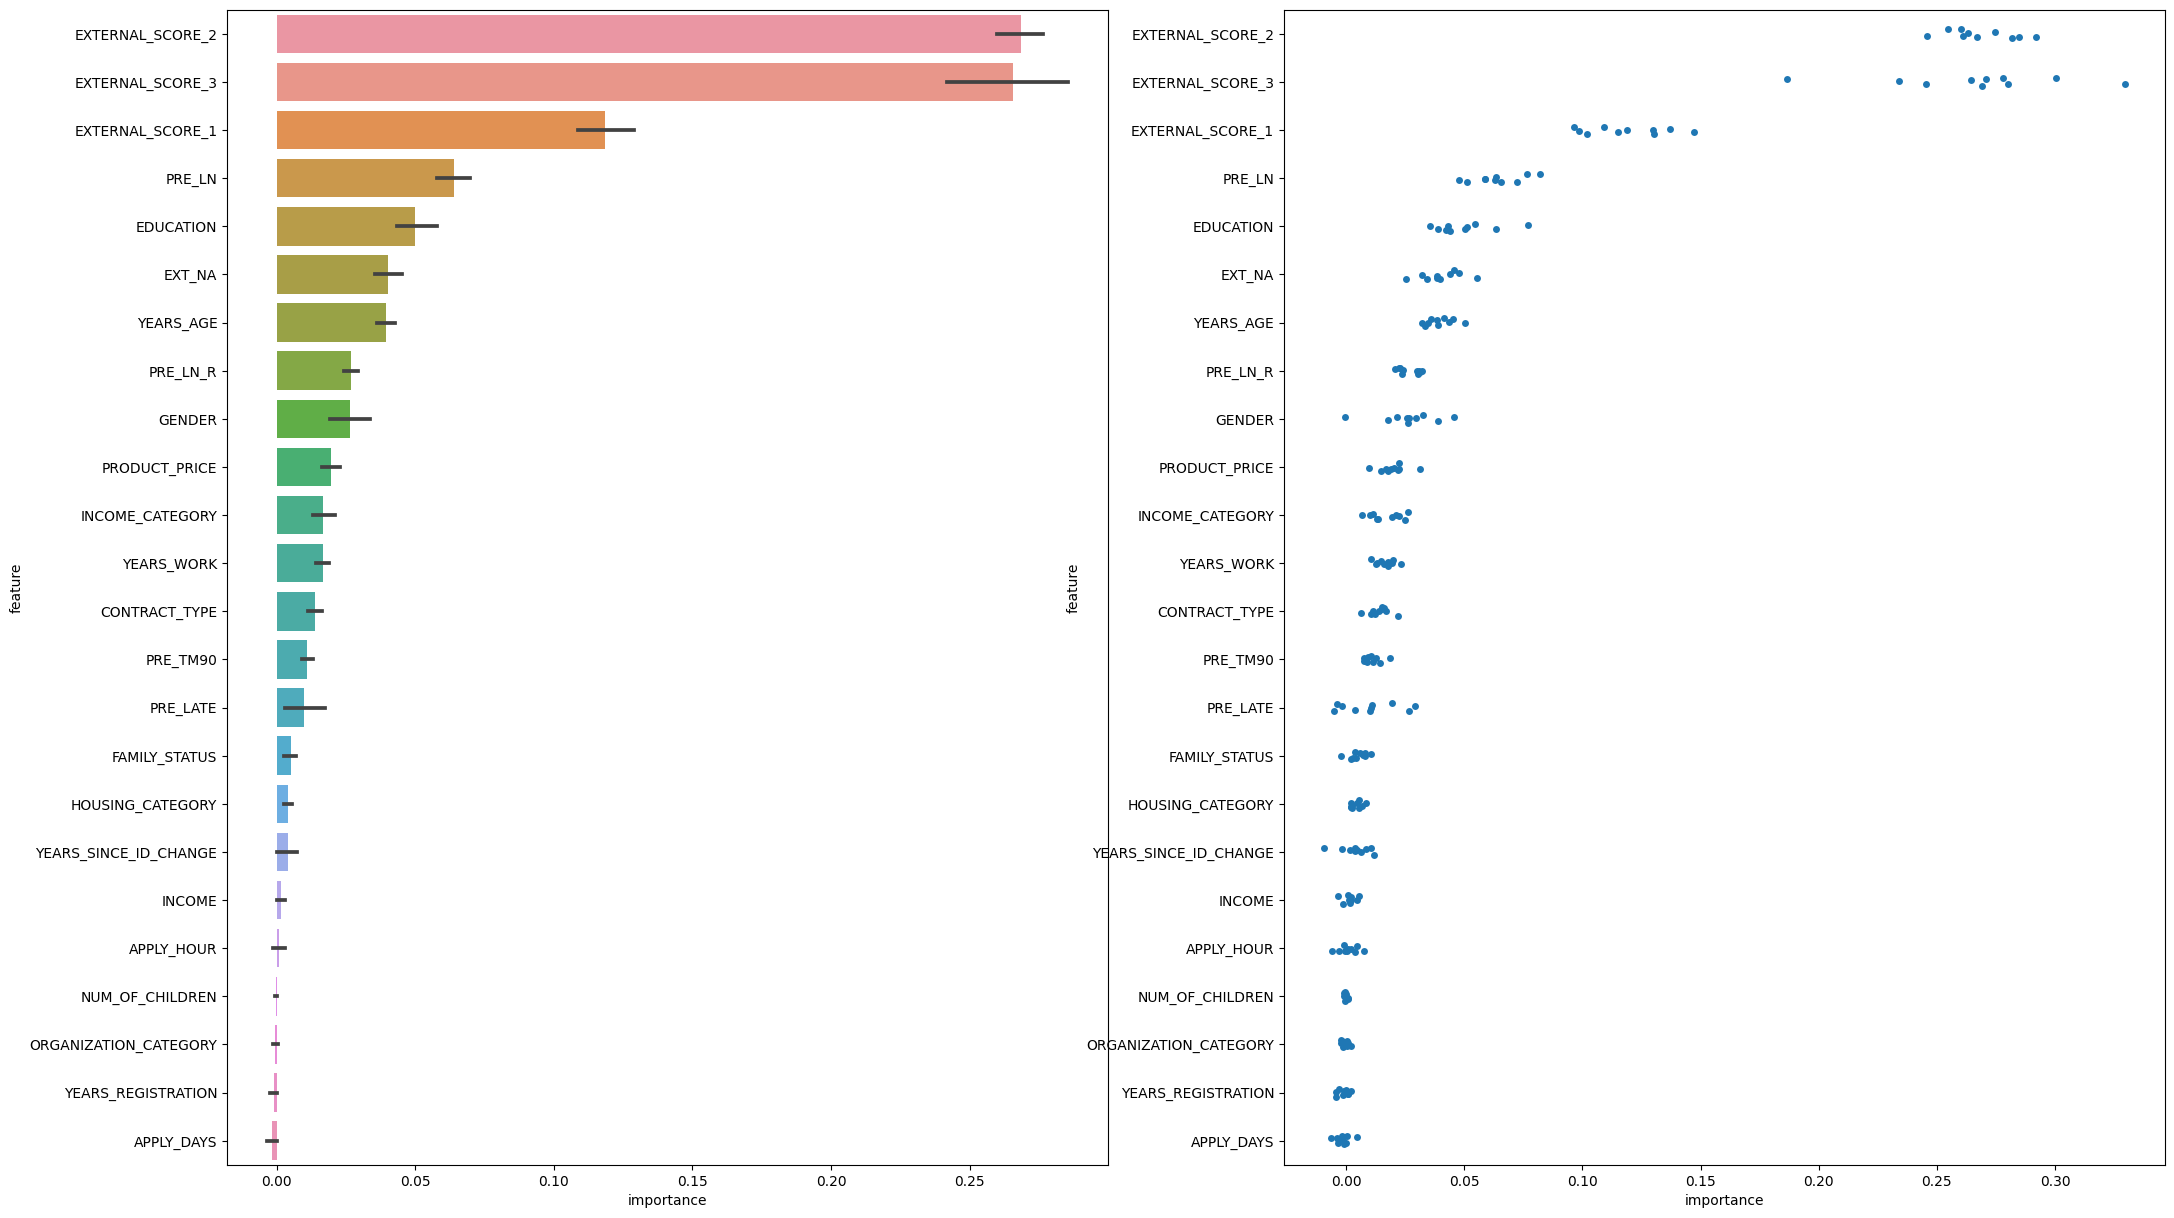

In [40]:
fi_cb = plot_fi(grid_cb)

In [41]:
def mo_data(model, data, pre="preprocess", clf="clf"):
    pre = model.best_estimator_.named_steps[pre]
    data = pre.transform(data)
    fitur = [j.split("__")[1] for j in pre.get_feature_names_out()]
    mod = model.best_estimator_.named_steps[clf]
    dat = pd.DataFrame(data, columns=fitur)
    return mod, dat

def id_shap1(model, data, pre="preprocess", clf="clf", which="all"):
    mod, dat = mo_data(model, data)
    shapval = shap.TreeExplainer(mod, approximate=True).shap_values(dat)
    return shapval, dat

def pl_shap1(val, data):
    plt.figure(figsize=(15,10))

    plt.subplot(1,2,1)
    shap.summary_plot(val, data, plot_size=None, show=False)
    plt.subplot(1,2,2)
    shap.summary_plot(val, data, plot_type="violin", color='coolwarm', plot_size=None, show=False)
    
    plt.tight_layout()
    plt.show()

def pl_shap2(val, data):
    fig, axes = plt.subplots(5, 5, figsize=(20,20))
    axes = axes.ravel()

    for i, var in enumerate(data.columns):
        shap.dependence_plot(var, val, data, ax=axes[i], show=False)   
        
    plt.tight_layout()
    plt.show()


In [42]:
valx, datx = id_shap1(grid_cb, Xva1)
pl_shap1(valx, datx)

pl_shap2(valx, datx)

In [43]:
def id_shap2(model, data, pre="preprocess", clf="clf", en = 1):
    mod, dat = mo_data(model, data)
    
    # individual
    datn = dat.iloc[en:(en+1),:]
    explainer = shap.TreeExplainer(mod, approximate=False)
    shap_values = explainer.shap_values(datn)
    return shap.force_plot(explainer.expected_value, shap_values, datn, matplotlib=True, show=False, contribution_threshold=0.1)

In [44]:
# Xva1.iloc[[2,5,94,32],:]

In [45]:
for j in [2,5,94,32]:
    id_shap2(grid_cb, Xva1, en=j)
    Xva1.iloc[j:(j+1),:] # getting the correct u know, instances.

plt.show()
plt.tight_layout()

### X. Feature Selection: Modeling

In [46]:
# this feature only
fimp = fi_cb.cumsum().query('importance < 0.96').index
print(fimp.shape)

kat_kol_f = Xtr1[fimp].select_dtypes("object").columns
num_kol_f = Xtr1[fimp].select_dtypes(exclude="object").columns

# transformer 1 and 2
kat_trf1; num_trf1

# merge preprocessing
pre1_f = ColumnTransformer(transformers=[
    ('kat', kat_trf1, kat_kol_f),
    ('num', num_trf1, num_kol_f)
])

# FOLD
rkf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=0)

In [47]:
res_f, grid_f =  baseliner_1(models, pre1_f)
display(res_f.filter(regex='^m', axis=1))

In [48]:
cb_f = imbpipeline(steps=[
    ("preprocess", pre1_f),
    ("clf", CatBoostClassifier(random_state=0, verbose=0))
])

param_grid_f = {
    'clf__learning_rate': [0.01, 0.02],
    'clf__iterations': [1000],
    'clf__subsample': [0.8],
    'clf__depth': [7],
    'clf__l2_leaf_reg': [6]
}

# param_grid = {
#     'clf__learning_rate': [0.1, 0.01, 0.001,0.005, 0.05],
#     'clf__iterations': [500, 750, 1000, 1500, 2000, 4000],
#     'clf__subsample': [0.6, 0.7, 0.8],
#     'clf__depth': [4, 5, 7, 9, 10],
#     'clf__l2_leaf_reg': [0.5, 1, 2, 4, 6, 8]
# }

grid_cb_f = GridSearchCV(estimator=cb_f, param_grid = param_grid_f, cv = rkf, 
                        scoring= {"acc": "accuracy", "roc": "roc_auc", "bal":"balanced_accuracy",
                                "f1m": 'f1_macro', "pre": 'precision', 'rec':'recall', "pr0":pr0, 're0':re0
                                }, 
                        refit = "roc")

In [49]:
# Melakukan tuning hyperparameter
grid_cb_f.fit(Xtr1, ytr1)

# Mendapatkan model terbaik
print("Best Parameter", grid_cb_f.best_params_)
print("Best Scorer", grid_cb_f.best_score_)

print(grid_cb_f.best_estimator_.get_params()["clf"].get_params())

## Model 1: Threshold Moving and Prediction

In [50]:
def PID_cal(x1, y1, model, df0=df_pre1, df2=df_tr1, kol="u_id approved_credit loan_annuity"):
    df = x1.join(y1)
    df1 = df0.copy()
    
    df = df.join(df2[kol.upper().split(" ")])
    df["PROB"] = model.predict_proba(x1)[:,1]
    
    df1['PID'] = (df1.LOAN_ANNUITY*df1.TERM_PAYMENT/(df1.APPROVED_CREDIT)-1)*(df1.CONTRACT_STATUS=='Approved')*(df1.CONTRACT_TYPE!='Revolving loans')
    df1['PID'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # using previous and overall mean
    c_PID = df1[['PID', "U_ID"]].dropna().groupby("U_ID")['PID'].mean().mean()
    df = df.join(df1[['PID', "U_ID"]].dropna().groupby(["U_ID"])['PID'].mean(), on="U_ID")
    df["PID"].fillna(c_PID, inplace=True)
    
#     # change it into median only
#     c_PID = df1.PID.median()

    print(c_PID)

    df = df["u_id approved_credit product_price contract_type income pid prob flag".upper().split(" ")]
    
    return df

In [51]:
def fLabel(pos_prob, thd):
    return (pos_prob >= thd).astype("int")

def fCustom(df, thd): #00, #01
    y0 = df.FLAG
    cr = df.APPROVED_CREDIT
    pi = df.PID
    y1 = fLabel(df.PROB, thd)
    
    tot = sum(cr*(1-y1))
    pro = sum(pi*cr*(1-y1)*(1-y0))
    los = sum(cr*(1-y0)*y1)
    
    return (pro-los)/tot
    
def fThresh(df, pid=23.16, thresh = np.arange(0.005, 0.995, 0.005)):
    y = df["FLAG"]
    yprob = df["PROB"]
    
    cm = [confusion_matrix(y, fLabel(yprob, t)) for t in thresh]
    pro1 = [fCustom(df, t) for t in thresh]
   
    # tn, fp, fn, tp
    am = np.array(cm).reshape((thresh.shape[0],4))[:,0:4]
    matrik = pd.DataFrame(am, columns=["tn", "fp", "fn", "tp"])
    matrik["thresh"] = thresh
    
    # f1 micro dari formula manual, cari max, yyy.
    matrik["acc"] = matrik[["tn", "tp"]].sum(1) /  matrik[["tn", "tp", "fn", "fp"]].sum(1)

    matrik["sen"] = matrik[["tp"]].sum(1) /  matrik[["tp", "fn"]].sum(1)
    matrik["pre"] = matrik[["tp"]].sum(1) /  matrik[["tp", "fp"]].sum(1)
    matrik["spe"] = matrik[["tn"]].sum(1) /  matrik[["tn", "fp"]].sum(1)
    matrik["bal"] = matrik[["sen", "spe"]].mean(1)
        
    matrik["f11"] = 2*matrik[["sen", "pre"]].prod(1) / matrik[["sen", "pre"]].sum(1)
    matrik["f10"] = 2*matrik["tn"] / (matrik[["tn", "fp", "fn"]]*[2,1,1]).sum(1)
    matrik["f1M"] = matrik[["f11", "f10"]].mean(1)
    matrik["pro2"]= (matrik[["tn", "fp", "fn", "tp"]]*[pid, 0, -100,0]).sum(1) / matrik[["tn", "tp", "fn", "fp"]].sum(1)
    
    matrik.reset_index(drop=True, inplace=True)
    
    matrik["pro1"] = pro1
    
    return matrik.dropna().sort_values("thresh", ascending=True)

In [52]:
# 92*profit + 8*loss 
(yva1.value_counts()[0]*.2316 + yva1.value_counts()[1]*-1)/yva1.shape[0]*100

13.208688018208422

In [53]:
# pd.set_option('display.max_rows', 60)
Xth1 = PID_cal(Xva1, yva1, model=grid_cb)

# recall untuk mengatasi risiko
display(fThresh(Xth1, pid=23.16).query("thresh == 0.5"))

# inverse precision buat mengatasi kerugian
fThresh(Xth1, pid=23.16).query("pro2 >= 13.5 & sen >= 0.20")

# pd.set_option('display.max_rows', 60)
Xth1 = PID_cal(Xte1, yte1, model=grid_cb)

# recall untuk mengatasi risiko
display(fThresh(Xth1, pid=23.16).query("thresh == 0.5|thresh == 0.16"))

# inverse precision buat mengatasi kerugian
fThresh(Xth1, pid=23.16).query("pro2 >= 13.5 & sen >= 0.20")


0.2316217089031235


,tn,fp,fn,tp,thresh,acc,sen,pre,spe,bal,f11,f10,f1M,pro2,pro1
99,5645,9,493,4,0.5,0.918387,0.008048,0.307692,0.998408,0.503228,0.015686,0.957429,0.486558,13.239831,0.210439


0.2316217089031235


,tn,fp,fn,tp,thresh,acc,sen,pre,spe,bal,f11,f10,f1M,pro2,pro1
31,12228,1330,770,433,0.16,0.857733,0.359933,0.245604,0.901903,0.630918,0.291976,0.920922,0.606449,13.969276,0.119258
99,13540,18,1190,13,0.50,0.918163,0.010806,0.419355,0.998672,0.504739,0.021070,0.957296,0.489183,13.182467,0.213209


,tn,fp,fn,tp,thresh,acc,sen,pre,spe,bal,f11,f10,f1M,pro2,pro1
23,11252,2306,609,594,0.120,0.802520,0.493766,0.204828,0.829916,0.661841,0.289544,0.885322,0.587433,13.528644,0.027292
24,11392,2166,635,568,0.125,0.810243,0.472153,0.207754,0.840242,0.656197,0.288545,0.890522,0.589533,13.572164,0.042334
25,11551,2007,661,542,0.130,0.819253,0.450540,0.212632,0.851969,0.651255,0.288913,0.896469,0.592691,13.645496,0.058546
26,11670,1888,680,523,0.135,0.826028,0.434746,0.216922,0.860746,0.647746,0.289430,0.900880,0.595155,13.703489,0.068619
27,11808,1750,701,502,0.140,0.833954,0.417290,0.222913,0.870925,0.644108,0.290593,0.905973,0.598283,13.777744,0.081255
28,11909,1649,719,484,0.145,0.839577,0.402328,0.226910,0.878374,0.640351,0.290168,0.909570,0.599869,13.814270,0.090880
29,12025,1533,730,473,0.150,0.846691,0.393184,0.235793,0.886930,0.640057,0.294796,0.913997,0.604396,13.921753,0.101387
30,12130,1428,751,452,0.155,0.852381,0.375727,0.240426,0.894675,0.635201,0.293221,0.917584,0.605402,13.944231,0.110840
31,12228,1330,770,433,0.160,0.857733,0.359933,0.245604,0.901903,0.630918,0.291976,0.920922,0.606449,13.969276,0.119258
32,12315,1243,781,422,0.165,0.862882,0.350790,0.253453,0.908320,0.629555,0.294282,0.924064,0.609173,14.031258,0.127270


# 5. Modeling 2 : Credit Limit Prediction
Menggunakan approved credit sebagai proksi dari credit limit.
1. Melakukan pemodelan dengan data train sebagai aproksimasi sistem awal
2. Dengan formula: AP ~ 'PRODUCT_PRICE', 'PROB', 'FLAG'
3. Model akan mencari formula aproksimasi sistem awal, termasuk mencari pengaruh dari FLAG0 dan FLAG1 terhadap Approved Credit dan sebaliknya
4. Dalam prediksi, akan digunakan FLAG=0 sehingga menurunkan credit limit dari tiap pelanggan, sehingga **diharapkan/diekspektasikan** semua pelanggan dengan Product Price (**Beban Awal**) dan Prob (Credit Score / **Risiko**) dapat membayar kredit. 

In [54]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
import statsmodels.api as sm

display(df_pre1.sample(4))
df_his.sample(4)

,SK_ID_PREV,U_ID,CONTRACT_TYPE,LOAN_ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRODUCT_PRICE,APPLY_DAYS,APPLY_HOUR,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
3218,1591687,400552,Cash loans,10849.860,90000.0,95940.0,0.0,90000.0,THURSDAY,10,Approved,-1966,12.0,high,365243.0,-1936.0,-1599.0,1.0
22618,2700652,176409,Consumer loans,8229.690,82305.0,74074.5,8230.5,82305.0,SUNDAY,12,Approved,-2759,10.0,low_normal,365243.0,-2727.0,-2451.0,0.0
241411,2813835,102481,Cash loans,51081.750,1125000.0,1125000.0,NaN,1125000.0,THURSDAY,10,Approved,-1030,48.0,middle,NaN,NaN,NaN,NaN
219584,2701130,400465,Cash loans,11721.735,90000.0,108837.0,NaN,90000.0,SUNDAY,15,Approved,-575,12.0,middle,365243.0,-545.0,-267.0,1.0


,SK_ID_PREV,U_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
39969,1627490,171041,10,-764.0,-788.0,5307.570,5307.570
2319334,2586193,137073,6,-1678.0,-1679.0,6186.465,6186.465
2300488,1948218,440824,3,-2860.0,-2866.0,3375.000,3375.000
2332809,1462636,154724,1,-328.0,-329.0,16508.790,16508.790


In [55]:
# data set preparation for #2
dtr2 = PID_cal(Xtr1, ytr1, grid_cb).drop(["PID", "CONTRACT_TYPE"], axis=1)
dva2 = PID_cal(Xva1, yva1, grid_cb).drop(["PID", "CONTRACT_TYPE"], axis=1)
dte2 = PID_cal(Xte1, yte1, grid_cb, df2=df_te1).drop(["PID", 'CONTRACT_TYPE'], axis=1)

0.2316217089031235
0.2316217089031235
0.2316217089031235


In [56]:
Xtr2 = dtr2.drop("U_ID", axis=1)
Xva2 = dva2.drop("U_ID", axis=1)
Xte2 = dte2.drop("U_ID", axis=1)

ytr2 = Xtr2.pop("APPROVED_CREDIT")
yva2 = Xva2.pop("APPROVED_CREDIT")
yte2 = Xte2.pop("APPROVED_CREDIT")

kat_kol_2 = Xtr2.select_dtypes("object").columns
num_kol_2 = Xtr2.select_dtypes(exclude="object").columns

# ordinal encoder and numeric scaler --> diff
kat_trf_2 = Pipeline(steps=[
    ("kat_en", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ("kat_im1", SimpleImputer(strategy="most_frequent")),
])

num_trf_2 = Pipeline(steps=[
    ("num_im", SimpleImputer(strategy="median")),
    ('num_sc', MinMaxScaler())
])

# merge preprocessing
pre_2 = ColumnTransformer(transformers=[
    ('kat', kat_trf_2, kat_kol_2),
    ('num', num_trf_2, num_kol_2)
])

# FOLD, the same as well
rkf_2 = RepeatedKFold(n_splits=3, n_repeats=2, random_state=0)

In [57]:
# list model, can't be optimized yet
mods_2 = [    
    Ridge(random_state=0),
    RandomForestRegressor(random_state=0),
    XGBRegressor(random_state=0),
    HistGradientBoostingRegressor(random_state=0),
    LGBMRegressor(random_state=0),
    ElasticNet(random_state=0),
    AdaBoostRegressor(random_state=0),
    CatBoostRegressor(random_state=0, verbose=0),
    LinearRegression(),
]

def baseliner_2(models=mods_2, pre=pre_2, ver=0):
    res0 = []

    for model in models:
        pipa = imbpipeline(steps=[
            ("preprocess", pre),
            ("clf", model)
        ])

        # weit, how to do? try append for dataframe
        grid_search = GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf_2, 
                                   scoring={"rmse": 'neg_root_mean_squared_error', "var": "explained_variance", 
                                            "mape":"neg_mean_absolute_percentage_error",'rsq': 'r2'}, 
                                   refit="mape", verbose=ver)

        grid_search.fit(Xtr2, ytr2)
        
        hmm = pd.DataFrame(grid_search.cv_results_).iloc[0].to_dict()
        hmm['model'] = type(model).__name__
        
        # Append the dictionary to the results list
        res0.append(hmm)
        
    res0 = pd.DataFrame(res0)
    
    return res0, grid_search

In [58]:
# res_base_2, grid_2 = baseliner_2()
# print(res_base_2.filter(regex='^m', axis=1).sort_values(['mean_test_mape'], ascending = False).to_markdown())

**Results**, mape is not in percentage, so around 8-91% error.

|    |   mean_fit_time |   mean_score_time |   mean_test_rmse |   mean_test_var |   mean_test_mape |   mean_test_rsq | model                         |
|---:|----------------:|------------------:|-----------------:|----------------:|-----------------:|----------------:|:------------------------------|
|  7 |       3.90168   |        0.0275559  |         -64612.3 |       0.974135  |       -0.0839811 |       0.974131  | CatBoostRegressor             |
|  4 |       0.457837  |        0.0586887  |         -64447.8 |       0.974271  |       -0.0842291 |       0.974267  | LGBMRegressor                 |
|  3 |       0.426409  |        0.0993339  |         -65421.3 |       0.973487  |       -0.0856124 |       0.973484  | HistGradientBoostingRegressor |
|  2 |       0.288543  |        0.0495159  |         -66312.7 |       0.972759  |       -0.085856  |       0.972754  | XGBRegressor                  |
|  1 |       7.85241   |        0.611078   |         -73880.2 |       0.966191  |       -0.0949913 |       0.966185  | RandomForestRegressor         |
|  8 |       0.0412332 |        0.00916163 |         -65008.7 |       0.973821  |       -0.0961106 |       0.973817  | LinearRegression              |
|  0 |       0.0357964 |        0.00873578 |         -65018.9 |       0.973813  |       -0.0974264 |       0.973808  | Ridge                         |
|  6 |       0.924293  |        0.046724   |         -77940.2 |       0.962567  |       -0.174608  |       0.962317  | AdaBoostRegressor             |
|  5 |       0.0419226 |        0.0101994  |        -394499   |       0.0359287 |       -0.913276  |       0.0358706 | ElasticNet                    |

In [59]:
Xtr2

,PRODUCT_PRICE,INCOME,PROB,FLAG
50421,855000.0,180000.0,0.024744,0
30672,450000.0,112500.0,0.029310,0
12891,121500.0,90000.0,0.055743,0
47880,90000.0,33750.0,0.080737,0
40664,1102500.0,180000.0,0.065171,0
...,...,...,...,...
15339,225000.0,157500.0,0.009065,0
20871,558000.0,175500.0,0.160189,0
23709,225000.0,76500.0,0.029131,0
24352,679500.0,112500.0,0.024621,0


In [60]:
# take a simpler model --> Linear Regression

# standardized 0-1
print(Xtr2.columns)
Xtr2lr = sm.add_constant(pre_2.fit_transform(Xtr2))
res_2 = sm.OLS(ytr2, Xtr2lr).fit()

print(res_2.summary())

Index(['PRODUCT_PRICE', 'INCOME', 'PROB', 'FLAG'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:        APPROVED_CREDIT   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                 5.149e+05
Date:                Tue, 20 Aug 2024   Prob (F-statistic):               0.00
Time:                        07:14:04   Log-Likelihood:            -6.9196e+05
No. Observations:               55352   AIC:                         1.384e+06
Df Residuals:                   55347   BIC:                         1.384e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [61]:
def pred_appr(df=dva2, pre=pre_2, model=res_2):
    pred = df.copy()
    
    X = pred.drop("U_ID", axis=1)
    X["FLAG"] = 0

    y = X.pop("APPROVED_CREDIT")

    X = sm.add_constant(pre.transform(X))

    pred["PRED"] = model.predict(X)
    print(sklearn.metrics.mean_absolute_percentage_error(y, pred.PRED), sklearn.metrics.r2_score(y, pred.PRED))

    return pred

In [62]:
pred_appr()

pte2 = pred_appr(dte2)
display(pte2.query("FLAG == 1").head())

# Approved Credit or Price is expected to be higher than pred --> T>F
print((pte2.query("FLAG == 1")[["APPROVED_CREDIT", "PRED"]].mul([1,-1]).sum(1)>0).value_counts())
print((pte2.query("FLAG == 1")[["PRODUCT_PRICE", "PRED"]].mul([1,-1]).sum(1)>0).value_counts())

# Approved Credit is expected to be lower than pred, well at least the same. T<F
print((pte2.query("FLAG == 0")[["APPROVED_CREDIT", "PRED"]].mul([1,-1]).sum(1)>0).value_counts())
print((pte2.query("FLAG == 0")[["PRODUCT_PRICE", "PRED"]].mul([1,-1]).sum(1)>0).value_counts())


0.09469972492877024 0.9738390447622093
0.09582636945441823 0.9738413275884705


,U_ID,APPROVED_CREDIT,PRODUCT_PRICE,INCOME,PROB,FLAG,PRED
23,240848,450000.0,450000.0,225000.0,0.285777,1,515275.196638
27,435327,942300.0,675000.0,315000.0,0.177080,1,750891.102554
35,433402,380533.5,328500.0,180000.0,0.280741,1,384253.721717
36,359942,1024290.0,855000.0,306000.0,0.357551,1,955758.514328
47,288729,698517.0,603000.0,135000.0,0.349227,1,684696.713010


True     637
False    566
Name: count, dtype: int64
False    1203
Name: count, dtype: int64
False    7457
True     6101
Name: count, dtype: int64
False    13558
Name: count, dtype: int64


# 6. Modeling 3 : Interest Rate Prediction
Menggunakan **Yield Group** sebagai proksi dari **Interest Rate**. Interest Rate tidak disediakan, meski bisa diaproksimasi dari loan annuity, approved credit, dan term, hal tersebut hanya dapat diaplikasikan pada data previous serta hanya untuk kontrak bertipe selain revolving loan. Sehingga, akan digunakan yield group sebagai proksi dari interset rate yang sudah disediakan di data previous application.

1. using prev data
1. take approved only and make into 3 class: 0, 1, 2 --> low, middle, high
1. do join, but using what? inner wae dah ya
1. train eval and test
1. IR ~ PROB + (CT) + APPR + PRICE + (TERM)
1. eval by test, then using approved predict

Tujuan utama adalah untuk meminimalisir risiko default. Pemodelan akan digunakan untuk aproksimasi sistem perusahaan, sedangkan risiko default debitur dapat diturunkan dengan menggunakan prediksi approved credit yang sudah mengandung bobot risiko.

### Lawas Version 

In [63]:
dtr3 = PID_cal(Xtr1, ytr1, grid_cb)
dva3 = PID_cal(Xva1, yva1, grid_cb)
dte3 = PID_cal(Xte1, yte1, grid_cb, df2=df_te1)

dtr3 = pred_appr(dtr3)
dva3 = pred_appr(dva3)
dte3 = pred_appr(dte3)

# # predict to minimize risk --> as a credit limit.
# # IR ~ PROB + CT + APPR + PRICE
kol_3 = "u_id yield_group contract_type approved_credit product_price".upper().split(" ")
dtr3 = pd.merge(df_pre1.query("CONTRACT_STATUS == 'Approved'")[kol_3], dtr3[["U_ID", "PROB", "PRED", "FLAG"]],  
                how='left', left_on=['U_ID'], right_on = ['U_ID']).dropna().query("YIELD_GROUP != 'NA1'")
dva3 = pd.merge(df_pre1.query("CONTRACT_STATUS == 'Approved'")[kol_3], dva3[["U_ID", "PROB", "PRED", "FLAG"]],  
                how='left', left_on=['U_ID'], right_on = ['U_ID']).dropna().query("YIELD_GROUP != 'NA1'")

print(dtr3.shape, dva3.shape, dva3.columns)

dva3.YIELD_GROUP.replace(['low_normal', 'middle', 'high', 'low_action'], [0,1,2,0], inplace=True)
dtr3.YIELD_GROUP.replace(['low_normal', 'middle', 'high', 'low_action'], [0,1,2,0], inplace=True)


0.2316217089031235
0.2316217089031235
0.2316217089031235
0.0957514309907469 0.9738171474430127
0.09469972492877024 0.9738390447622093
0.09582636945441823 0.9738413275884705
(144599, 8) (16133, 8) Index(['U_ID', 'YIELD_GROUP', 'CONTRACT_TYPE', 'APPROVED_CREDIT',
       'PRODUCT_PRICE', 'PROB', 'PRED', 'FLAG'],
      dtype='object')


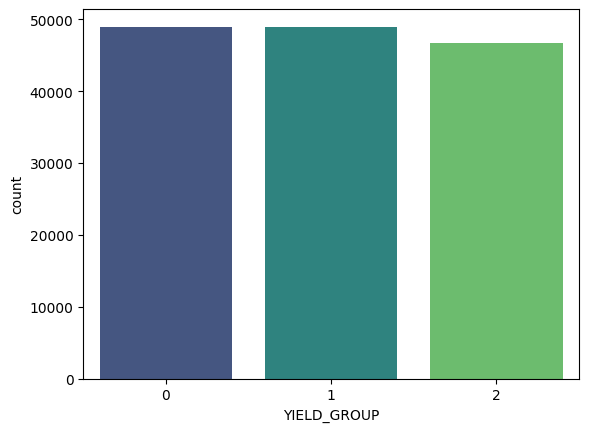

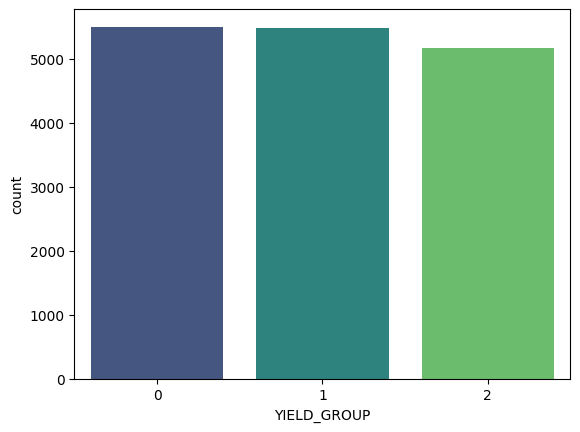

In [64]:
sns.countplot(x="YIELD_GROUP", data=dtr3, palette="viridis")
plt.show()
sns.countplot(x="YIELD_GROUP", data=dva3, palette="viridis")
plt.show()

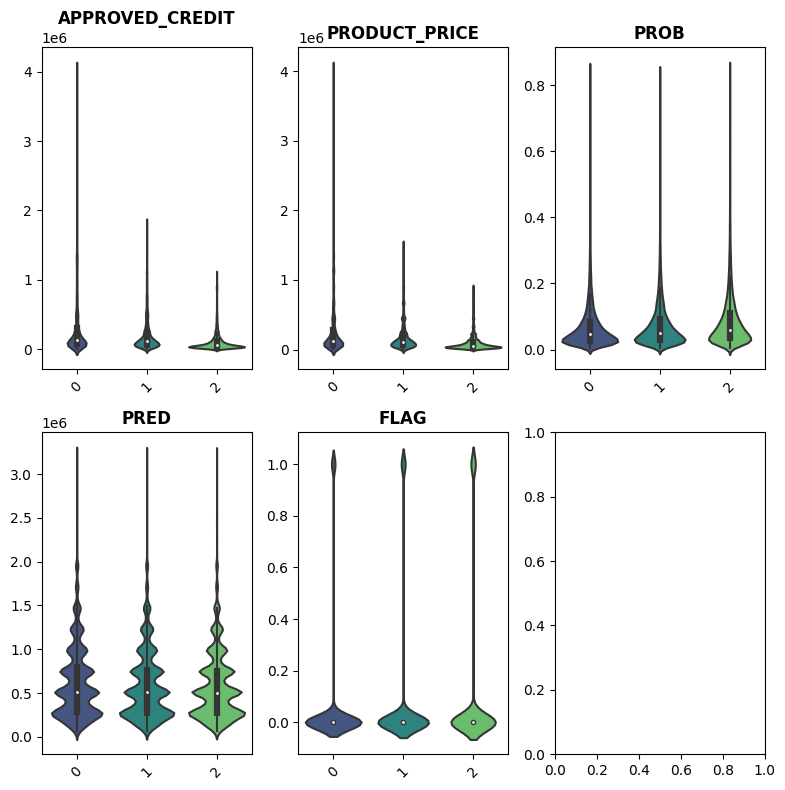

In [65]:
fig, axes = plt.subplots(2, 3, figsize=(8, 8), sharey=False)
axes = axes.ravel()

for i, var in enumerate(['APPROVED_CREDIT','PRODUCT_PRICE', 'PROB', 'PRED', 'FLAG']):
    sns.violinplot(data=dtr3, y=var, x="YIELD_GROUP", ax=axes[i], palette="viridis")
    axes[i].set_title(f'{var}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', rotation=45)
    pass

plt.tight_layout()
plt.show()


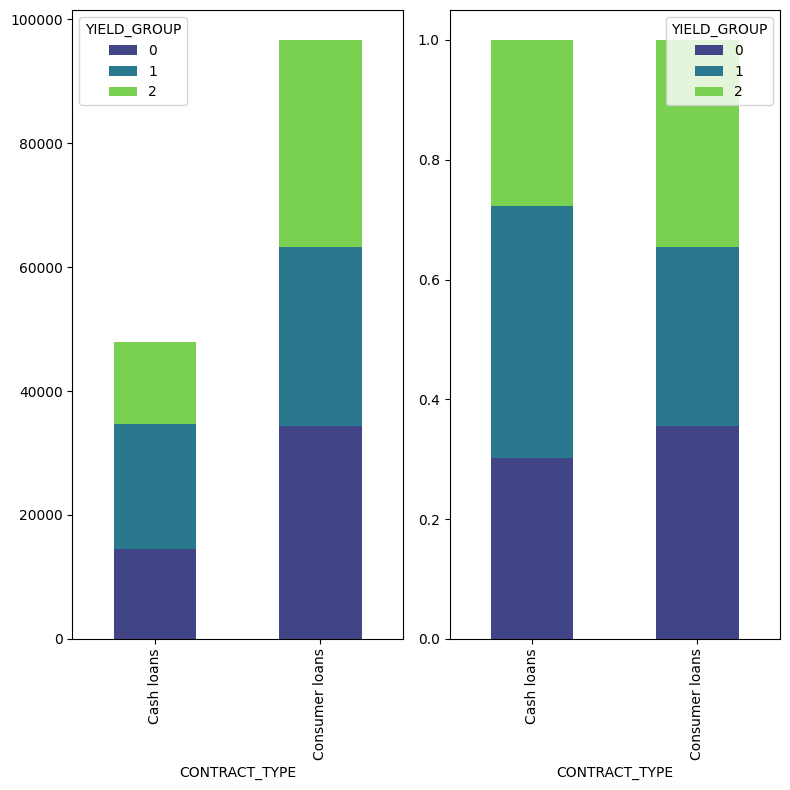

In [66]:
# Bar Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharey=False)
axes = axes.ravel()

tbl = pd.crosstab(dtr3["CONTRACT_TYPE"], dtr3["YIELD_GROUP"])
tbl.plot(kind="bar", stacked=True, color=["#414487FF", "#2A788EFF", "#7AD151FF"], ax=axes[0])

tbl = pd.crosstab(dtr3["CONTRACT_TYPE"], dtr3["YIELD_GROUP"], normalize="index")
tbl.plot(kind="bar", stacked=True, color=["#414487FF", "#2A788EFF", "#7AD151FF"], ax=axes[1])

plt.tight_layout()
plt.show()

In [67]:
Xtr3 = dtr3.drop(['U_ID', 'PRED', 'FLAG'], axis=1)
Xva3 = dva3.drop(['U_ID', 'FLAG'], axis=1) # doing 2: using approved and change approved using pred
Xte3 = dte3.drop(['U_ID', 'FLAG'], axis=1) # this as well

ytr3 = Xtr3.pop("YIELD_GROUP")
yva3 = Xva3.pop("YIELD_GROUP")

kat_kol_3 = Xtr3.select_dtypes("object").columns
num_kol_3 = Xtr3.select_dtypes(exclude="object").columns

# ordinal encoder and numeric scaler --> diff
kat_trf_3 = Pipeline(steps=[
    ("kat_en", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ("kat_im1", SimpleImputer(strategy="most_frequent")),
])

num_trf_3 = Pipeline(steps=[
    ("num_im", SimpleImputer(strategy="median")),
    ('num_sc', MinMaxScaler())
])

# merge preprocessing
pre_3 = ColumnTransformer(transformers=[
    ('kat', kat_trf_3, kat_kol_3),
    ('num', num_trf_3, num_kol_3)
])

# FOLD, the same as well
rskf_3 = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=0)

In [68]:
# models
mods_3 = [
    LogisticRegression(random_state=0,multi_class='multinomial',solver='lbfgs', max_iter=500),
    RandomForestClassifier(random_state=0),
    XGBClassifier(random_state=0),
    HistGradientBoostingClassifier(random_state=0),
    LGBMClassifier(random_state=0),
    AdaBoostClassifier(random_state=0),
    CatBoostClassifier(random_state=0, verbose=0),
]

def baseliner_3(models=mods_3, pre=pre_3, Xtr=Xtr3, ytr=ytr3, ver=0):
    res0 = []

    for model in models:
        pipa = imbpipeline(steps=[
            ("preprocess", pre_3),
            ("clf", model)
        ])

        # weit, how to do? try append for dataframe
        grid_search = GridSearchCV(estimator=pipa, param_grid = {}, cv=rskf_3, 
                                   scoring={"acc": "accuracy", "ovo": 'roc_auc_ovo', 
                                            "ovr":"roc_auc_ovr","f1m": 'f1_macro'}, 
                                   refit="acc", verbose=ver)

        grid_search.fit(Xtr, ytr)
        hmm = pd.DataFrame(grid_search.cv_results_).iloc[0].to_dict()
        hmm['model'] = type(model).__name__
        # Append the dictionary to the results list
        res0.append(hmm)
        
    res0 = pd.DataFrame(res0)
    
    return res0, grid_search

In [69]:
res_base_3, grid_3 = baseliner_3(ver=3)
# print(res_base_3.filter(regex='^m', axis=1).sort_values(['mean_test_ovo'], ascending = False).to_markdown())

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END  acc: (test=0.492) f1m: (test=0.469) ovo: (test=0.684) ovr: (test=0.684) total time=   3.0s
[CV 2/4] END  acc: (test=0.491) f1m: (test=0.469) ovo: (test=0.683) ovr: (test=0.682) total time=   2.6s
[CV 3/4] END  acc: (test=0.490) f1m: (test=0.467) ovo: (test=0.682) ovr: (test=0.681) total time=   3.2s
[CV 4/4] END  acc: (test=0.494) f1m: (test=0.471) ovo: (test=0.685) ovr: (test=0.684) total time=   2.7s
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END  acc: (test=0.521) f1m: (test=0.520) ovo: (test=0.705) ovr: (test=0.704) total time=  26.8s
[CV 2/4] END  acc: (test=0.514) f1m: (test=0.513) ovo: (test=0.702) ovr: (test=0.701) total time=  26.9s
[CV 3/4] END  acc: (test=0.517) f1m: (test=0.515) ovo: (test=0.702) ovr: (test=0.702) total time=  26.2s
[CV 4/4] END  acc: (test=0.516) f1m: (test=0.516) ovo: (test=0.705) ovr: (test=0.704) total time=  26.6s
Fitting 4 folds for each of 1 candidates, 

**Results: Not yet optimized**

|    |   mean_fit_time |   mean_score_time |   mean_test_acc |   mean_test_ovo |   mean_test_ovr |   mean_test_f1m | model                          |
|---:|----------------:|------------------:|----------------:|----------------:|----------------:|----------------:|:-------------------------------|
|  6 |        14.9339  |          0.604526 |        0.530429 |        0.723034 |        0.722274 |        0.525471 | CatBoostClassifier             |
|  4 |         2.24143 |          1.05596  |        0.531013 |        0.722675 |        0.721841 |        0.525198 | LGBMClassifier                 |
|  2 |         1.98043 |          0.914412 |        0.529841 |        0.72217  |        0.721403 |        0.525184 | XGBClassifier                  |
|  3 |         2.55474 |          3.00966  |        0.530017 |        0.721937 |        0.721115 |        0.524591 | HistGradientBoostingClassifier |
|  1 |        19.473   |          4.29915  |        0.517006 |        0.703421 |        0.702903 |        0.516129 | RandomForestClassifier         |
|  5 |         2.6282  |          0.907876 |        0.496124 |        0.68983  |        0.688546 |        0.494551 | AdaBoostClassifier             |
|  0 |         1.45762 |          0.234496 |        0.491967 |        0.683509 |        0.682732 |        0.46904  | LogisticRegression             |

In [70]:
# predict 
pva3a = grid_3.predict(Xva3)

Xva3b = Xva3.copy()
Xva3b["APPROVED_CREDIT"] = Xva3b["PRED"]
pva3b = grid_3.predict(Xva3b)

Xte3b = Xte3.copy()
Xte3b["APPROVED_CREDIT"] = Xte3b["PRED"]
pte3b = grid_3.predict(Xte3b)

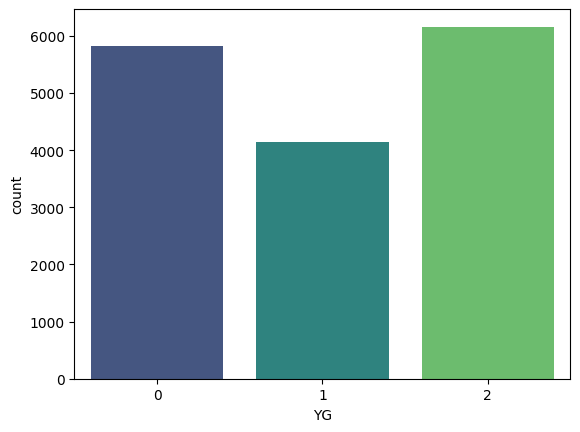

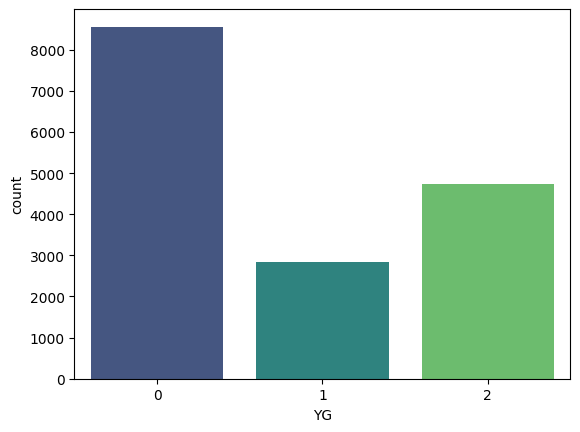

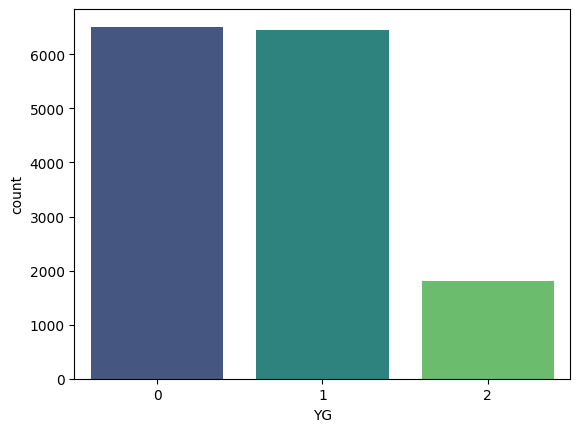

In [71]:
sns.countplot(x="YG", data=pd.DataFrame(pva3a, columns=["YG"]), palette="viridis")
plt.show()

sns.countplot(x="YG", data=pd.DataFrame(pva3b, columns=["YG"]), palette="viridis")
plt.show()

sns.countplot(x="YG", data=pd.DataFrame(pte3b, columns=["YG"]), palette="viridis")
plt.show()

In [72]:
# eval using ovo and acc
sklearn.metrics.accuracy_score(yva3, pva3a), sklearn.metrics.accuracy_score(yva3, pva3b)

(0.5387714622202938, 0.417157379284696)